### Gap Junction Segmentation Model Training Pipeline

In [1]:
#Libraries
import torch
from torch import nn
from utilities import UpBlock, DownBlock, DoubleConv, GenDLoss, FocalLoss
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.optim import AdamW, SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import BinaryRecall, BinaryPrecision, BinaryF1Score
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import os
import cv2
from tqdm.notebook import tqdm #Change to tqdm.tqdm if not using Jupyter Notebook
import copy
import wandb
#Custom Libraries
from resize_image import resize_image

In [ ]:
#WandB Initialization
wandb.login(key="04e003d2c64e518f8033ab016c7a0036545c05f5")
wandb.init(project="gap-junction-segmentation", 
           entity="zhen_lab",
           name="unet_pooled_run_1",
           dir="/home/tommytang111/gap-junction-segmentation/wandb/unet_pooled_runs",
           reinit=True,
           config={
               "learning_rate": 0.001,
               "batch_size": 8,
               "epochs": 30,
               "image_size": (512, 512),
               "loss_function": "Generalized Dice Loss",
               "optimizer": "Adam",
               "scheduler": "ReduceLROnPlateau"
           }
)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/tommytang111/.netrc
wandb: Currently logged in as: tommytang111 (zhen_lab) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


#### Set Reproducible Seeds

In [2]:
def seed_everything(seed: int = 42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    #torch.backends.cudnn.benchmark = False
    
def worker_init_fn(worker_id):
    seed = 42 + worker_id
    np.random.seed(seed)
    torch.manual_seed(seed)
    
seed_everything(42)

#### Define Augmentation Options

In [ ]:
# Custom augmentation
def get_custom_augmentation():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Affine(scale=(0.9,1.1), rotate=10, translate_percent=0.15, shear = (-5, 5), p=0.9),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.2, p=0.5),
        A.GaussNoise(p=0.3),
        A.Normalize(mean=0.0, std=1.0),
        A.Resize(512, 512),
        ToTensorV2()
    ])
    
def get_custom_augmentation2():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Affine(scale=(0.8,1.2), rotate=360, translate_percent=0.15, shear=(-15, 15), p=0.9),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.GaussNoise(p=0.3),
        A.Normalize(mean=0.0, std=1.0),
        A.Resize(512, 512),
        ToTensorV2()
    ])

# Light augmentation for gap junction segmentation
def get_light_augmentation():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Transpose(p=0.5),
        A.GaussNoise(p=0.3),
        A.Blur(blur_limit=3, p=0.2),
        A.Normalize(mean=0.0, std=1.0),  # For grayscale
        ToTensorV2()
    ])

# Medium augmentation
def get_medium_augmentation():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Transpose(p=0.5),
        A.ShiftScaleRotate(
            shift_limit=0.1, 
            scale_limit=0.2, 
            rotate_limit=15, 
            border_mode=cv2.BORDER_CONSTANT, 
            value=0, 
            p=0.5
        ),
        A.ElasticTransform(
            alpha=1, 
            sigma=50, 
            alpha_affine=50, 
            border_mode=cv2.BORDER_CONSTANT, 
            value=0, 
            p=0.3
        ),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
        A.Blur(blur_limit=3, p=0.2),
        A.CLAHE(clip_limit=2.0, p=0.3),
        A.Normalize(mean=0.0, std=1.0),
        ToTensorV2()
    ])
    
# Heavy augmentation
def get_heavy_augmentation():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Transpose(p=0.5),
        A.ShiftScaleRotate(
            shift_limit=0.15, 
            scale_limit=0.3, 
            rotate_limit=25, 
            border_mode=cv2.BORDER_CONSTANT, 
            value=0, 
            p=0.6
        ),
        A.ElasticTransform(
            alpha=1, 
            sigma=50, 
            alpha_affine=50, 
            border_mode=cv2.BORDER_CONSTANT, 
            value=0, 
            p=0.4
        ),
        A.GridDistortion(p=0.3),
        A.OpticalDistortion(p=0.3),
        A.GaussNoise(var_limit=(10.0, 80.0), p=0.4),
        A.OneOf([
            A.Blur(blur_limit=3),
            A.GaussianBlur(blur_limit=3),
            A.MedianBlur(blur_limit=3),
        ], p=0.3),
        A.CLAHE(clip_limit=2.0, p=0.4),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
        A.Normalize(mean=0.0, std=1.0),
        ToTensorV2()
    ])

#### Make Dataset Class

In [4]:
#Class can load any mask as long as the model corresponds to the mask type
class TrainingDataset(Dataset):
    def __init__(self, images, labels, masks=None, augmentation=None, data_size=(512, 512), train=True):
        self.image_paths = sorted([os.path.join(images, img) for img in os.listdir(images)])
        self.label_paths = sorted([os.path.join(labels, lbl) for lbl in os.listdir(labels)])
        self.mask_paths = sorted([os.path.join(masks, mask) for mask in os.listdir(masks)]) if masks else None
        self.augmentation = augmentation
        self.data_size = data_size
        self.train = train

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        #Read image, label, and mask
        image = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
        label = cv2.imread(self.label_paths[idx], cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE) if self.mask_paths else None
        
        #Apply resizing with padding if image is not expected size and then convert back to ndarray
        if (image.shape[0] != self.data_size[0]) or (image.shape[1] != self.data_size[1]): 
            image = np.array(resize_image(image, self.data_size[0], self.data_size[1], (0,0,0)))
            label = np.array(resize_image(label, self.data_size[0], self.data_size[1], (0,0,0)))
            if mask is not None:
                mask = np.array(resize_image(mask, self.data_size[0], self.data_size[1], (0,0,0)))

        #Convert mask/label to binary for model classification
        label[label > 0] = 1
        if mask is not None:
            mask[mask > 0] = 1
        
        #Apply augmentation if provided
        if self.augmentation and self.train:
            if mask is not None:
                #Use mask in augmentation
                augmented = self.augmentation(image=image, mask=label, label=mask)
                image = augmented['image']
                label = augmented['mask']
                mask = augmented['label']
            else:
                #Without mask
                augmented = self.augmentation(image=image, mask=label)
                image = augmented['image']
                label = augmented['mask']

        #Add entity recognition clause later if needed
        
        # Convert to tensors if not already converted from augmentation
        if not torch.is_tensor(image):
            image = ToTensor()(image).float()
        if not torch.is_tensor(label):
            label = torch.from_numpy(label).long()
        if mask is not None and not torch.is_tensor(mask):
            mask = torch.from_numpy(mask).long()
        elif mask is None:
            mask = torch.zeros_like(label)

        return image, label, mask

#### Set Augmentation

In [8]:
#For training with augmentation
train_augmentation = get_custom_augmentation()  # Change to get_medium_augmentation() or get_heavy_augmentation() as needed

# For validation without augmentation
valid_augmentation = A.Compose([
    A.Normalize(mean=0.0, std=1.0),
    ToTensorV2()
])

#### Initialize and Load Datasets

In [9]:
train = TrainingDataset(
    images="/home/tommytang111/gap-junction-segmentation/data/sem_adult/SEM_split/s250-259/imgs",
    labels="/home/tommytang111/gap-junction-segmentation/data/sem_adult/SEM_split/s250-259/gts",
    augmentation=train_augmentation,
    train=True,
)

valid = TrainingDataset(
    images="/home/tommytang111/gap-junction-segmentation/data/sem_adult/SEM_split/s200-209/imgs",
    labels="/home/tommytang111/gap-junction-segmentation/data/sem_adult/SEM_split/s200-209/gts",
    augmentation=valid_augmentation,
    train=False
)

train_dataloader = DataLoader(train, batch_size=8, shuffle=True, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid, batch_size=8, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)

#### Initialize model and send to gpu

In [5]:
class UNet(nn.Module):
    """UNet Architecture"""
    def __init__(self, out_classes=2, up_sample_mode='conv_transpose', three=False, attend=False, residual=False, scale=False, spatial=False, dropout=0, classes=2):
        """Initialize the UNet model"""
        super(UNet, self).__init__()
        self.three = three
        self.up_sample_mode = up_sample_mode
        self.dropout=dropout

        # Downsampling Path
        self.down_conv1 = DownBlock(1, 64, three=three, spatial=False, residual=residual) # 3 input channels --> 64 output channels
        self.down_conv2 = DownBlock(64, 128, three=three, spatial=spatial, dropout=self.dropout, residual=residual) # 64 input channels --> 128 output channels
        self.down_conv3 = DownBlock(128, 256, spatial=spatial, dropout=self.dropout, residual=residual) # 128 input channels --> 256 output channels
        self.down_conv4 = DownBlock(256, 512, spatial=spatial, dropout=self.dropout, residual=residual) # 256 input channels --> 512 output channels
        # Bottleneck
        self.double_conv = DoubleConv(512, 1024,spatial=spatial, dropout=self.dropout, residual=residual)
        # Upsampling Path
        self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode, dropout=self.dropout, residual=residual) # 512 + 1024 input channels --> 512 output channels
        self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode, dropout=self.dropout, residual=residual)
        self.up_conv2 = UpBlock(128+ 256, 128, self.up_sample_mode, dropout=self.dropout, residual=residual)
        self.up_conv1 = UpBlock(128 + 64, 64, self.up_sample_mode)
        # Final Convolution
        self.conv_last = nn.Conv2d(64, 1 if classes == 2 else classes, kernel_size=1)
        self.attend = attend
        if scale:
            self.s1, self.s2 = torch.nn.Parameter(torch.ones(1), requires_grad=True), torch.nn.Parameter(torch.ones(1), requires_grad=True) # learn scaling


    def forward(self, x):
        """Forward pass of the UNet model
        x: (16, 1, 512, 512)
        """
        # print(x.shape)
        x, skip1_out = self.down_conv1(x) # x: (16, 64, 256, 256), skip1_out: (16, 64, 512, 512) (batch_size, channels, height, width)    
        x, skip2_out = self.down_conv2(x) # x: (16, 128, 128, 128), skip2_out: (16, 128, 256, 256)
        if self.three: x = x.squeeze(-3)   
        x, skip3_out = self.down_conv3(x) # x: (16, 256, 64, 64), skip3_out: (16, 256, 128, 128)
        x, skip4_out = self.down_conv4(x) # x: (16, 512, 32, 32), skip4_out: (16, 512, 64, 64)
        x = self.double_conv(x) # x: (16, 1024, 32, 32)
        x = self.up_conv4(x, skip4_out) # x: (16, 512, 64, 64)
        x = self.up_conv3(x, skip3_out) # x: (16, 256, 128, 128)
        if self.three: 
            #attention_mode???
            skip1_out = torch.mean(skip1_out, dim=2)
            skip2_out = torch.mean(skip2_out, dim=2)
        x = self.up_conv2(x, skip2_out) # x: (16, 128, 256, 256)
        x = self.up_conv1(x, skip1_out) # x: (16, 64, 512, 512)
        x = self.conv_last(x) # x: (16, 1, 512, 512)
        return x
    
device = torch.device("cuda")    
model = UNet().to(device)

#### Initialize loss function and optimizer

In [11]:
loss_fn = GenDLoss()
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, min_lr=1e-6)

In [12]:
#Send evaluation metrics to device
recall = BinaryRecall().to(device)
precision = BinaryPrecision().to(device)
f1 = BinaryF1Score().to(device)

#### Define Training and Validation Process

In [13]:
#Define training function
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    train_loss = 0
    num_batches = len(dataloader)
    
    #Reset metrics for each epoch
    recall.reset()
    precision.reset()
    f1.reset()
    
    for batch, (X, y, _) in tqdm(enumerate(dataloader), total=num_batches, desc="Training Batches"):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        #Calculate metrics after converting predictions to binary
        pred_binary = (torch.sigmoid(pred) > 0.5).squeeze(1) #Remove channel dimension to match y
        
        #Update metrics
        recall.update(pred_binary, y)
        precision.update(pred_binary, y)
        f1.update(pred_binary, y)
        
        train_loss += loss.item()

    #Compute final metrics per epoch
    train_recall = recall.compute().item()
    train_precision = precision.compute().item()
    train_f1 = f1.compute().item()
    train_loss_per_epoch = train_loss / num_batches 
    
    return train_loss_per_epoch, train_recall, train_precision, train_f1


In [14]:
#Define validation function
def validate(dataloader, model, loss_fn):
    model.eval()
    test_loss = 0
    num_batches = len(dataloader)
    
    #Reset metrics for each epoch
    recall.reset()
    precision.reset()
    f1.reset()
    
    with torch.no_grad():
        for X, y, _ in tqdm(dataloader, desc="Validation Batches"):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            
        #Calculate metrics
        pred_binary = (torch.sigmoid(pred) > 0.5).squeeze(1) #Remove channel dimension to match y
        
        #Update metrics
        recall.update(pred_binary, y)
        precision.update(pred_binary, y)
        f1.update(pred_binary, y)
            
        #Compute final metrics per epoch
        val_recall = recall.compute().item()
        val_precision = precision.compute().item()
        val_f1 = f1.compute().item()
        val_loss_per_epoch = test_loss / num_batches

    return val_loss_per_epoch, val_recall, val_precision, val_f1
    print(f"Avg loss: {test_loss:>7f}\n")
    

#### Run Training

In [ ]:
# Clear GPU memory before training
torch.cuda.empty_cache()

epochs = 50
best_f1 = 0.0
best_val_loss = float('inf')
best_epoch = 0
best_model_state = copy.deepcopy(model.state_dict())

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    
    #Training
    train_loss, train_recall, train_precision, train_f1 = train(train_dataloader, model, loss_fn, optimizer)

    #Validation
    val_loss, val_recall, val_precision, val_f1 = validate(valid_dataloader, model, loss_fn)

    #Update learning rate scheduler
    scheduler.step(val_loss)
    
    #Print metrics
    print(f"Train | Loss: {train_loss:.4f}, Recall: {train_recall:.4f}, Precision: {train_precision:.4f}, F1: {train_f1:.4f}")
    print(f"Val   | Loss: {val_loss:.4f}, Recall: {val_recall:.4f}, Precision: {val_precision:.4f}, F1: {val_f1:.4f}")
    print("-----------------------------")
    
    #Log best model state based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
    
    #Log best model state based on F1 score
    if val_f1 > best_f1:
        best_f1 = val_f1
        best_epoch = epoch
        best_model_state = copy.deepcopy(model.state_dict())
        
    #Log metrics to wandb
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_recall": train_recall,
        "train_precision": train_precision,
        "train_f1": train_f1,
        "val_loss": val_loss,
        "val_recall": val_recall,
        "val_precision": val_precision,
        "val_f1": val_f1,
        "best_val_f1": best_f1,
        "best_val_loss": best_val_loss,
        "best_epoch": best_epoch,
        "lr": optimizer.param_groups[0]["lr"]
    })

print("Training Complete!")
wandb.finish()

Epoch 1


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9567, Recall: 0.2601, Precision: 0.0221, F1: 0.0408
Val   | Loss: 0.9300, Recall: 0.9825, Precision: 0.0341, F1: 0.0660
-----------------------------
Epoch 2


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9580, Recall: 0.2990, Precision: 0.0212, F1: 0.0395
Val   | Loss: 0.9281, Recall: 0.9831, Precision: 0.0343, F1: 0.0664
-----------------------------
Epoch 3


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9568, Recall: 0.2420, Precision: 0.0219, F1: 0.0402
Val   | Loss: 0.8956, Recall: 0.0103, Precision: 0.0132, F1: 0.0115
-----------------------------
Epoch 4


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2460, Precision: 0.0242, F1: 0.0441
Val   | Loss: 0.8746, Recall: 0.1495, Precision: 0.1403, F1: 0.1447
-----------------------------
Epoch 5


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9564, Recall: 0.1940, Precision: 0.0229, F1: 0.0410
Val   | Loss: 0.9345, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 6


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.1739, Precision: 0.0252, F1: 0.0440
Val   | Loss: 0.9254, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 7


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9567, Recall: 0.0530, Precision: 0.0292, F1: 0.0376
Val   | Loss: 0.9257, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 8


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9572, Recall: 0.0000, Precision: 0.0286, F1: 0.0001
Val   | Loss: 0.9139, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 9


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9583, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.9135, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 10


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9578, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.9193, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 11


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9569, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.9133, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 12


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9562, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.9257, Recall: 0.0001, Precision: 0.0332, F1: 0.0002
-----------------------------
Epoch 13


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9531, Recall: 0.0005, Precision: 0.0142, F1: 0.0009
Val   | Loss: 0.8888, Recall: 0.0018, Precision: 0.0528, F1: 0.0035
-----------------------------
Epoch 14


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9503, Recall: 0.0386, Precision: 0.0281, F1: 0.0325
Val   | Loss: 0.9297, Recall: 0.0325, Precision: 0.0302, F1: 0.0313
-----------------------------
Epoch 15


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9414, Recall: 0.0468, Precision: 0.0370, F1: 0.0414
Val   | Loss: 0.9309, Recall: 0.0341, Precision: 0.0294, F1: 0.0316
-----------------------------
Epoch 16


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9343, Recall: 0.0440, Precision: 0.0412, F1: 0.0426
Val   | Loss: 0.9306, Recall: 0.0332, Precision: 0.0281, F1: 0.0305
-----------------------------
Epoch 17


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9311, Recall: 0.0772, Precision: 0.0439, F1: 0.0559
Val   | Loss: 0.9339, Recall: 0.0441, Precision: 0.0277, F1: 0.0341
-----------------------------
Epoch 18


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9303, Recall: 0.0852, Precision: 0.0454, F1: 0.0592
Val   | Loss: 0.9324, Recall: 0.0469, Precision: 0.0306, F1: 0.0370
-----------------------------
Epoch 19


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9298, Recall: 0.0639, Precision: 0.0456, F1: 0.0532
Val   | Loss: 0.9300, Recall: 0.0312, Precision: 0.0286, F1: 0.0298
-----------------------------
Epoch 20


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9284, Recall: 0.0714, Precision: 0.0511, F1: 0.0596
Val   | Loss: 0.9345, Recall: 0.0317, Precision: 0.0273, F1: 0.0294
-----------------------------
Epoch 21


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9315, Recall: 0.0601, Precision: 0.0431, F1: 0.0502
Val   | Loss: 0.9314, Recall: 0.0301, Precision: 0.0297, F1: 0.0299
-----------------------------
Epoch 22


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9232, Recall: 0.0824, Precision: 0.0510, F1: 0.0630
Val   | Loss: 0.9323, Recall: 0.0318, Precision: 0.0287, F1: 0.0302
-----------------------------
Epoch 23


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9233, Recall: 0.0868, Precision: 0.0467, F1: 0.0607
Val   | Loss: 0.9365, Recall: 0.0360, Precision: 0.0266, F1: 0.0306
-----------------------------
Epoch 24


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9227, Recall: 0.0855, Precision: 0.0496, F1: 0.0628
Val   | Loss: 0.9288, Recall: 0.0306, Precision: 0.0309, F1: 0.0308
-----------------------------
Epoch 25


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9257, Recall: 0.0803, Precision: 0.0450, F1: 0.0577
Val   | Loss: 0.9284, Recall: 0.0302, Precision: 0.0311, F1: 0.0306
-----------------------------
Epoch 26


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9234, Recall: 0.0844, Precision: 0.0473, F1: 0.0606
Val   | Loss: 0.9280, Recall: 0.0271, Precision: 0.0318, F1: 0.0293
-----------------------------
Epoch 27


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9188, Recall: 0.0843, Precision: 0.0527, F1: 0.0648
Val   | Loss: 0.9279, Recall: 0.0269, Precision: 0.0317, F1: 0.0291
-----------------------------
Epoch 28


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9198, Recall: 0.0829, Precision: 0.0523, F1: 0.0641
Val   | Loss: 0.9279, Recall: 0.0270, Precision: 0.0318, F1: 0.0292
-----------------------------
Epoch 29


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9218, Recall: 0.0764, Precision: 0.0506, F1: 0.0609
Val   | Loss: 0.9282, Recall: 0.0252, Precision: 0.0319, F1: 0.0282
-----------------------------
Epoch 30


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9150, Recall: 0.0829, Precision: 0.0577, F1: 0.0680
Val   | Loss: 0.9285, Recall: 0.0249, Precision: 0.0318, F1: 0.0279
-----------------------------
Epoch 31


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9213, Recall: 0.0703, Precision: 0.0512, F1: 0.0592
Val   | Loss: 0.9287, Recall: 0.0246, Precision: 0.0316, F1: 0.0277
-----------------------------
Epoch 32


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9208, Recall: 0.0684, Precision: 0.0535, F1: 0.0600
Val   | Loss: 0.9287, Recall: 0.0244, Precision: 0.0314, F1: 0.0275
-----------------------------
Epoch 33


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9197, Recall: 0.0705, Precision: 0.0538, F1: 0.0610
Val   | Loss: 0.9289, Recall: 0.0259, Precision: 0.0311, F1: 0.0283
-----------------------------
Epoch 34


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9234, Recall: 0.0659, Precision: 0.0498, F1: 0.0567
Val   | Loss: 0.9289, Recall: 0.0264, Precision: 0.0314, F1: 0.0286
-----------------------------
Epoch 35


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9171, Recall: 0.0736, Precision: 0.0564, F1: 0.0639
Val   | Loss: 0.9290, Recall: 0.0263, Precision: 0.0312, F1: 0.0285
-----------------------------
Epoch 36


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9240, Recall: 0.0606, Precision: 0.0486, F1: 0.0540
Val   | Loss: 0.9293, Recall: 0.0250, Precision: 0.0309, F1: 0.0276
-----------------------------
Epoch 37


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9171, Recall: 0.0708, Precision: 0.0584, F1: 0.0640
Val   | Loss: 0.9293, Recall: 0.0263, Precision: 0.0311, F1: 0.0285
-----------------------------
Epoch 38


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9210, Recall: 0.0688, Precision: 0.0523, F1: 0.0594
Val   | Loss: 0.9294, Recall: 0.0264, Precision: 0.0310, F1: 0.0285
-----------------------------
Epoch 39


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9195, Recall: 0.0753, Precision: 0.0551, F1: 0.0637
Val   | Loss: 0.9292, Recall: 0.0267, Precision: 0.0311, F1: 0.0287
-----------------------------
Epoch 40


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9229, Recall: 0.0704, Precision: 0.0497, F1: 0.0583
Val   | Loss: 0.9291, Recall: 0.0257, Precision: 0.0308, F1: 0.0280
-----------------------------
Epoch 41


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9176, Recall: 0.0814, Precision: 0.0581, F1: 0.0678
Val   | Loss: 0.9288, Recall: 0.0251, Precision: 0.0315, F1: 0.0279
-----------------------------
Epoch 42


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9160, Recall: 0.0813, Precision: 0.0581, F1: 0.0678
Val   | Loss: 0.9287, Recall: 0.0251, Precision: 0.0316, F1: 0.0280
-----------------------------
Epoch 43


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9185, Recall: 0.0787, Precision: 0.0565, F1: 0.0658
Val   | Loss: 0.9286, Recall: 0.0250, Precision: 0.0317, F1: 0.0280
-----------------------------
Epoch 44


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9198, Recall: 0.0719, Precision: 0.0534, F1: 0.0612
Val   | Loss: 0.9285, Recall: 0.0243, Precision: 0.0313, F1: 0.0273
-----------------------------
Epoch 45


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9159, Recall: 0.0791, Precision: 0.0578, F1: 0.0668
Val   | Loss: 0.9283, Recall: 0.0248, Precision: 0.0316, F1: 0.0278
-----------------------------
Epoch 46


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9180, Recall: 0.0750, Precision: 0.0548, F1: 0.0633
Val   | Loss: 0.9284, Recall: 0.0242, Precision: 0.0313, F1: 0.0273
-----------------------------
Epoch 47


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9153, Recall: 0.0792, Precision: 0.0576, F1: 0.0667
Val   | Loss: 0.9283, Recall: 0.0252, Precision: 0.0318, F1: 0.0281
-----------------------------
Epoch 48


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9207, Recall: 0.0760, Precision: 0.0522, F1: 0.0619
Val   | Loss: 0.9283, Recall: 0.0268, Precision: 0.0315, F1: 0.0289
-----------------------------
Epoch 49


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9188, Recall: 0.0795, Precision: 0.0525, F1: 0.0632
Val   | Loss: 0.9283, Recall: 0.0268, Precision: 0.0315, F1: 0.0290
-----------------------------
Epoch 50


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9217, Recall: 0.0774, Precision: 0.0511, F1: 0.0615
Val   | Loss: 0.9284, Recall: 0.0267, Precision: 0.0314, F1: 0.0288
-----------------------------
Epoch 51


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9201, Recall: 0.0799, Precision: 0.0533, F1: 0.0639
Val   | Loss: 0.9284, Recall: 0.0266, Precision: 0.0313, F1: 0.0288
-----------------------------
Epoch 52


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9198, Recall: 0.0802, Precision: 0.0539, F1: 0.0644
Val   | Loss: 0.9285, Recall: 0.0265, Precision: 0.0314, F1: 0.0288
-----------------------------
Epoch 53


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9181, Recall: 0.0818, Precision: 0.0556, F1: 0.0662
Val   | Loss: 0.9286, Recall: 0.0259, Precision: 0.0310, F1: 0.0282
-----------------------------
Epoch 54


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9155, Recall: 0.0842, Precision: 0.0581, F1: 0.0688
Val   | Loss: 0.9286, Recall: 0.0252, Precision: 0.0317, F1: 0.0281
-----------------------------
Epoch 55


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9221, Recall: 0.0720, Precision: 0.0506, F1: 0.0595
Val   | Loss: 0.9286, Recall: 0.0251, Precision: 0.0317, F1: 0.0280
-----------------------------
Epoch 56


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9210, Recall: 0.0758, Precision: 0.0535, F1: 0.0627
Val   | Loss: 0.9286, Recall: 0.0251, Precision: 0.0317, F1: 0.0280
-----------------------------
Epoch 57


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9177, Recall: 0.0769, Precision: 0.0549, F1: 0.0641
Val   | Loss: 0.9286, Recall: 0.0251, Precision: 0.0317, F1: 0.0280
-----------------------------
Epoch 58


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9190, Recall: 0.0737, Precision: 0.0530, F1: 0.0617
Val   | Loss: 0.9287, Recall: 0.0249, Precision: 0.0315, F1: 0.0278
-----------------------------
Epoch 59


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9141, Recall: 0.0827, Precision: 0.0592, F1: 0.0690
Val   | Loss: 0.9288, Recall: 0.0249, Precision: 0.0314, F1: 0.0278
-----------------------------
Epoch 60


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9242, Recall: 0.0707, Precision: 0.0500, F1: 0.0586
Val   | Loss: 0.9288, Recall: 0.0248, Precision: 0.0313, F1: 0.0277
-----------------------------
Epoch 61


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9231, Recall: 0.0728, Precision: 0.0507, F1: 0.0598
Val   | Loss: 0.9288, Recall: 0.0246, Precision: 0.0312, F1: 0.0275
-----------------------------
Epoch 62


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9182, Recall: 0.0801, Precision: 0.0552, F1: 0.0653
Val   | Loss: 0.9288, Recall: 0.0246, Precision: 0.0312, F1: 0.0275
-----------------------------
Epoch 63


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

#### Save Best Model

In [12]:
#Save the best logged model state
torch.save(best_model_state, "/home/tommytang111/gap-junction-segmentation/models/unet_v1.pt")
print("Saved PyTorch Model to unet_v1.pt")

Saved PyTorch Model to unet_v1.pt


#### Wandb Agentic Sweep

In [6]:
#Define sweep configuration
sweep_config = {
    'method': 'bayes',  # or 'random', 'bayes'
    'metric': {
        'name': 'val_f1',
        'goal': 'maximize'
    },
    'parameters': {
        'learning_rate': {
            'values': [0.01, 0.001, 0.0001]
        },
        'batch_size': {
            'values': [8]
        },
        'optimizer': {
            'values': ['AdamW']
        },
        'loss_function': {
            'values': ['GenDLoss']
        },
        'dropout': {
            'values': [0, 0.1]
        },
        'augmentation': {
            'values': ['custom1', 'custom2']
        },
    }
}

In [7]:
def train(dataloader, model, loss_fn, optimizer, recall, precision, f1):
    model.train()
    train_loss = 0
    num_batches = len(dataloader)
    
    # Reset metrics for each epoch
    recall.reset()
    precision.reset()
    f1.reset()
    
    for batch, (X, y, _) in tqdm(enumerate(dataloader), total=num_batches, desc="Training", leave=False):
        X, y = X.to(device), y.to(device)
        # Special handling for BCEWithLogitsLoss
        if y.dim() == 3:
            y = y.unsqueeze(1).float()
        
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # Calculate metrics after converting predictions to binary
        pred_binary = (torch.sigmoid(pred) > 0.5).squeeze(1)
        
        # Update metrics
        if y.dim() == 4 and y.size(1) == 1:
            y = y.squeeze(1)  # [B, 1, H, W] -> [B, H, W]
        recall.update(pred_binary, y)
        precision.update(pred_binary, y)
        f1.update(pred_binary, y)
        
        train_loss += loss.item()

    # Compute final metrics per epoch
    train_recall = recall.compute().item()
    train_precision = precision.compute().item()
    train_f1 = f1.compute().item()
    train_loss_per_epoch = train_loss / num_batches 
    
    return train_loss_per_epoch, train_recall, train_precision, train_f1

def validate(dataloader, model, loss_fn, recall, precision, f1):
    model.eval()
    test_loss = 0
    num_batches = len(dataloader)
    
    # Reset metrics for each epoch
    recall.reset()
    precision.reset()
    f1.reset()
    
    with torch.no_grad():
        for X, y, _ in tqdm(dataloader, desc="Validation", leave=False):
            X, y = X.to(device), y.to(device)
            #Special handling for BCEWithLogitsLoss
            if y.dim() == 3:
                y = y.unsqueeze(1).float()
            
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            
            # Calculate metrics
            pred_binary = (torch.sigmoid(pred) > 0.5).squeeze(1)
            
            # Update metrics
            if y.dim() == 4 and y.size(1) == 1:
                y = y.squeeze(1)  # [B, 1, H, W] -> [B, H, W]
            recall.update(pred_binary, y)
            precision.update(pred_binary, y)
            f1.update(pred_binary, y)
            
    # Compute final metrics per epoch
    val_recall = recall.compute().item()
    val_precision = precision.compute().item()
    val_f1 = f1.compute().item()
    val_loss_per_epoch = test_loss / num_batches

    return val_loss_per_epoch, val_recall, val_precision, val_f1

In [8]:
def train_model():
    # Initialize wandb run
    wandb.login(key="04e003d2c64e518f8033ab016c7a0036545c05f5")
    wandb.init(
        project="gap-junction-segmentation",
        entity="zhen_lab",
        dir="/home/tommytang111/gap-junction-segmentation/wandb"
    )
    
    # Get hyperparameters from wandb config
    config = wandb.config
    
    # Set seeds
    seed_everything(42)
    
    # Get augmentation strategy from config, default to 'medium'
    aug_strategy = config.get('augmentation', 'custom2')

    if aug_strategy == 'custom1':
        train_aug = get_custom_augmentation()
    elif aug_strategy == 'custom2':
        train_aug = get_custom_augmentation2()

    valid_aug = A.Compose([A.Normalize(mean=0.0, std=1.0), ToTensorV2()])

    # Initialize datasets with config batch size
    train_dataset = TrainingDataset(
        images="/home/tommytang111/gap-junction-segmentation/data/pooled/train/imgs",
        labels="/home/tommytang111/gap-junction-segmentation/data/pooled/train/gts",
        augmentation=train_aug,
        train=True
    )
    
    valid_dataset = TrainingDataset(
        images="/home/tommytang111/gap-junction-segmentation/data/pooled/val/imgs",
        labels="/home/tommytang111/gap-junction-segmentation/data/pooled/val/gts",
        augmentation=valid_aug,
        train=False
    )
    
    train_dataloader = DataLoader(
        train_dataset, 
        batch_size=config.batch_size, 
        shuffle=True, 
        num_workers=4, 
        pin_memory=True, 
        worker_init_fn=worker_init_fn
    )
    valid_dataloader = DataLoader(
        valid_dataset, 
        batch_size=config.batch_size, 
        shuffle=False, 
        num_workers=4, 
        pin_memory=True, 
        worker_init_fn=worker_init_fn
    )
    
    # Initialize model with config dropout
    device = torch.device("cuda")
    model = UNet(dropout=config.dropout).to(device)
    
    #Loss function mapping
    if config.loss_function == "GenDLoss":
        loss_fn = GenDLoss()
    #elif config.loss_function == "BCEWithLogitsLoss":
        #loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([2.0], device=device))
    elif config.loss_function == "FocalLoss":
        loss_fn = FocalLoss(alpha=torch.Tensor([0.08, 0.92]), device=device)

    #Optimizer mapping
    if config.optimizer == "AdamW":
        optimizer = AdamW(model.parameters(), lr=config.learning_rate, weight_decay=1e-4)
    elif config.optimizer == "SGD":
        optimizer = SGD(model.parameters(), lr=config.learning_rate, momentum=0.9, weight_decay=1e-4)
    
    # Initialize learning rate scheduler
    scheduler = ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        factor=0.5, 
        patience=10, 
        min_lr=1e-6
    )
    
    # Initialize metrics
    recall = BinaryRecall().to(device)
    precision = BinaryPrecision().to(device)
    f1 = BinaryF1Score().to(device)
    
    # Training loop
    torch.cuda.empty_cache()
    epochs = 50  # Reduced for sweep
    best_f1 = 0.0
    best_val_loss = float('inf')
    best_epoch = 0
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}")
        
        # Training
        train_loss, train_recall, train_precision, train_f1 = train(
            train_dataloader, model, loss_fn, optimizer, recall, precision, f1
        )
        
        # Validation
        val_loss, val_recall, val_precision, val_f1 = validate(
            valid_dataloader, model, loss_fn, recall, precision, f1
        )
        
        # Update learning rate scheduler
        scheduler.step(val_loss)
        
        # Print metrics
        print(f"Train | Loss: {train_loss:.4f}, Recall: {train_recall:.4f}, Precision: {train_precision:.4f}, F1: {train_f1:.4f}")
        print(f"Val   | Loss: {val_loss:.4f}, Recall: {val_recall:.4f}, Precision: {val_precision:.4f}, F1: {val_f1:.4f}")
        print("-----------------------------")

        # Log best model state
        if val_loss < best_val_loss:
            best_val_loss = val_loss
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_epoch = epoch
            best_model_state = copy.deepcopy(model.state_dict())
            # Save best model for this run
            model_path = f"/home/tommytang111/gap-junction-segmentation/models/sweep_model_{wandb.run.id}.pt"
            
        # Log metrics to wandb
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_recall": train_recall,
            "train_precision": train_precision,
            "train_f1": train_f1,
            "val_loss": val_loss,
            "val_recall": val_recall,
            "val_precision": val_precision,
            "val_f1": val_f1,
            "best_val_f1": best_f1,
            "best_val_loss": best_val_loss,
            "best_epoch": best_epoch,
            "lr": optimizer.param_groups[0]["lr"]
        })

    print("Training Complete!")
    torch.save(best_model_state, model_path)
    print("Saved PyTorch Model to ", model_path)
    wandb.finish()


In [9]:
#Initialize sweep
sweep_id = wandb.sweep(sweep_config, project="gap-junction-segmentation")
print(f"Sweep ID: {sweep_id}")

# Start the sweep agent
wandb.agent(sweep_id=sweep_id, function=train_model)

Create sweep with ID: dwqzhjxz
Sweep URL: https://wandb.ai/zhen_lab/gap-junction-segmentation/sweeps/dwqzhjxz
Sweep ID: dwqzhjxz


wandb: Agent Starting Run: pr14wefd with config:
wandb: 	augmentation: custom2
wandb: 	batch_size: 8
wandb: 	dropout: 0.1
wandb: 	learning_rate: 0.01
wandb: 	loss_function: GenDLoss
wandb: 	optimizer: AdamW
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/tommytang111/.netrc
wandb: Currently logged in as: tommytang111 (zhen_lab) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8937, Recall: 0.4149, Precision: 0.0576, F1: 0.1012
Val   | Loss: 0.8881, Recall: 0.1346, Precision: 0.2777, F1: 0.1813
-----------------------------
Epoch 2


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8643, Recall: 0.3498, Precision: 0.0873, F1: 0.1397
Val   | Loss: 0.8661, Recall: 0.1805, Precision: 0.1412, F1: 0.1585
-----------------------------
Epoch 3


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8560, Recall: 0.3475, Precision: 0.0829, F1: 0.1339
Val   | Loss: 0.8277, Recall: 0.3535, Precision: 0.1497, F1: 0.2103
-----------------------------
Epoch 4


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8526, Recall: 0.4042, Precision: 0.0899, F1: 0.1472
Val   | Loss: 0.8012, Recall: 0.3100, Precision: 0.1197, F1: 0.1727
-----------------------------
Epoch 5


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8351, Recall: 0.3747, Precision: 0.1086, F1: 0.1684
Val   | Loss: 0.7696, Recall: 0.3099, Precision: 0.1615, F1: 0.2124
-----------------------------
Epoch 6


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8468, Recall: 0.3583, Precision: 0.0965, F1: 0.1520
Val   | Loss: 0.7678, Recall: 0.3640, Precision: 0.1721, F1: 0.2337
-----------------------------
Epoch 7


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8418, Recall: 0.3839, Precision: 0.1060, F1: 0.1661
Val   | Loss: 0.7498, Recall: 0.3876, Precision: 0.1890, F1: 0.2541
-----------------------------
Epoch 8


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8316, Recall: 0.4049, Precision: 0.1061, F1: 0.1681
Val   | Loss: 0.8140, Recall: 0.2623, Precision: 0.1690, F1: 0.2056
-----------------------------
Epoch 9


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8273, Recall: 0.3684, Precision: 0.1074, F1: 0.1663
Val   | Loss: 0.7630, Recall: 0.3482, Precision: 0.2094, F1: 0.2616
-----------------------------
Epoch 10


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8256, Recall: 0.3978, Precision: 0.1184, F1: 0.1825
Val   | Loss: 0.7679, Recall: 0.4616, Precision: 0.1780, F1: 0.2569
-----------------------------
Epoch 11


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8258, Recall: 0.3979, Precision: 0.1106, F1: 0.1731
Val   | Loss: 0.8313, Recall: 0.3120, Precision: 0.1719, F1: 0.2216
-----------------------------
Epoch 12


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8137, Recall: 0.4009, Precision: 0.1197, F1: 0.1844
Val   | Loss: 0.7586, Recall: 0.5822, Precision: 0.1560, F1: 0.2461
-----------------------------
Epoch 13


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8088, Recall: 0.3908, Precision: 0.1086, F1: 0.1700
Val   | Loss: 0.9008, Recall: 0.1194, Precision: 0.2744, F1: 0.1664
-----------------------------
Epoch 14


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8104, Recall: 0.3674, Precision: 0.1158, F1: 0.1761
Val   | Loss: 0.7428, Recall: 0.5593, Precision: 0.1739, F1: 0.2654
-----------------------------
Epoch 15


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8069, Recall: 0.3728, Precision: 0.1136, F1: 0.1741
Val   | Loss: 0.7336, Recall: 0.5271, Precision: 0.1758, F1: 0.2636
-----------------------------
Epoch 16


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8148, Recall: 0.4145, Precision: 0.1281, F1: 0.1957
Val   | Loss: 0.8293, Recall: 0.3559, Precision: 0.1838, F1: 0.2424
-----------------------------
Epoch 17


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8138, Recall: 0.3423, Precision: 0.1195, F1: 0.1771
Val   | Loss: 0.7739, Recall: 0.4672, Precision: 0.1737, F1: 0.2533
-----------------------------
Epoch 18


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8094, Recall: 0.3877, Precision: 0.1328, F1: 0.1978
Val   | Loss: 0.7659, Recall: 0.6278, Precision: 0.1470, F1: 0.2382
-----------------------------
Epoch 19


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7902, Recall: 0.3900, Precision: 0.1503, F1: 0.2170
Val   | Loss: 0.7440, Recall: 0.5575, Precision: 0.1733, F1: 0.2644
-----------------------------
Epoch 20


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7906, Recall: 0.3906, Precision: 0.1349, F1: 0.2005
Val   | Loss: 0.8319, Recall: 0.2125, Precision: 0.2930, F1: 0.2463
-----------------------------
Epoch 21


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7892, Recall: 0.4533, Precision: 0.1329, F1: 0.2056
Val   | Loss: 0.7205, Recall: 0.3963, Precision: 0.2457, F1: 0.3033
-----------------------------
Epoch 22


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7817, Recall: 0.4270, Precision: 0.1506, F1: 0.2227
Val   | Loss: 0.7253, Recall: 0.6402, Precision: 0.1722, F1: 0.2714
-----------------------------
Epoch 23


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7643, Recall: 0.4111, Precision: 0.1476, F1: 0.2172
Val   | Loss: 0.8293, Recall: 0.2005, Precision: 0.3809, F1: 0.2627
-----------------------------
Epoch 24


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7540, Recall: 0.4394, Precision: 0.1532, F1: 0.2272
Val   | Loss: 0.6792, Recall: 0.5303, Precision: 0.2280, F1: 0.3189
-----------------------------
Epoch 25


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7773, Recall: 0.4871, Precision: 0.1380, F1: 0.2151
Val   | Loss: 0.7202, Recall: 0.4532, Precision: 0.2283, F1: 0.3037
-----------------------------
Epoch 26


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7684, Recall: 0.4049, Precision: 0.1805, F1: 0.2497
Val   | Loss: 0.7205, Recall: 0.2959, Precision: 0.3372, F1: 0.3152
-----------------------------
Epoch 27


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7583, Recall: 0.4223, Precision: 0.1664, F1: 0.2387
Val   | Loss: 0.8166, Recall: 0.1993, Precision: 0.3893, F1: 0.2636
-----------------------------
Epoch 28


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7595, Recall: 0.4125, Precision: 0.1817, F1: 0.2523
Val   | Loss: 0.7408, Recall: 0.7093, Precision: 0.1588, F1: 0.2595
-----------------------------
Epoch 29


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7358, Recall: 0.4307, Precision: 0.1891, F1: 0.2628
Val   | Loss: 0.7425, Recall: 0.3960, Precision: 0.2455, F1: 0.3031
-----------------------------
Epoch 30


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7586, Recall: 0.4162, Precision: 0.1638, F1: 0.2351
Val   | Loss: 0.7105, Recall: 0.4537, Precision: 0.2423, F1: 0.3159
-----------------------------
Epoch 31


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7647, Recall: 0.4049, Precision: 0.1642, F1: 0.2336
Val   | Loss: 0.6976, Recall: 0.3641, Precision: 0.3531, F1: 0.3585
-----------------------------
Epoch 32


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7818, Recall: 0.4385, Precision: 0.1602, F1: 0.2346
Val   | Loss: 0.7964, Recall: 0.7891, Precision: 0.1255, F1: 0.2165
-----------------------------
Epoch 33


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7469, Recall: 0.4521, Precision: 0.1819, F1: 0.2594
Val   | Loss: 0.8594, Recall: 0.1567, Precision: 0.2921, F1: 0.2040
-----------------------------
Epoch 34


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7439, Recall: 0.4760, Precision: 0.1698, F1: 0.2503
Val   | Loss: 0.6653, Recall: 0.5158, Precision: 0.2721, F1: 0.3562
-----------------------------
Epoch 35


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7482, Recall: 0.4694, Precision: 0.1919, F1: 0.2725
Val   | Loss: 0.6366, Recall: 0.5689, Precision: 0.2706, F1: 0.3668
-----------------------------
Epoch 36


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7238, Recall: 0.4375, Precision: 0.2135, F1: 0.2870
Val   | Loss: 0.6807, Recall: 0.4353, Precision: 0.3194, F1: 0.3685
-----------------------------
Epoch 37


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7263, Recall: 0.4610, Precision: 0.2003, F1: 0.2792
Val   | Loss: 0.7327, Recall: 0.3987, Precision: 0.2562, F1: 0.3119
-----------------------------
Epoch 38


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7220, Recall: 0.4801, Precision: 0.2178, F1: 0.2997
Val   | Loss: 0.7013, Recall: 0.4486, Precision: 0.2730, F1: 0.3394
-----------------------------
Epoch 39


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7162, Recall: 0.4436, Precision: 0.2522, F1: 0.3216
Val   | Loss: 0.8987, Recall: 0.0789, Precision: 0.7376, F1: 0.1425
-----------------------------
Epoch 40


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7052, Recall: 0.4766, Precision: 0.2251, F1: 0.3058
Val   | Loss: 0.6592, Recall: 0.3959, Precision: 0.4766, F1: 0.4325
-----------------------------
Epoch 41


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6909, Recall: 0.4940, Precision: 0.2455, F1: 0.3280
Val   | Loss: 0.5951, Recall: 0.5815, Precision: 0.3203, F1: 0.4131
-----------------------------
Epoch 42


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7014, Recall: 0.4428, Precision: 0.2698, F1: 0.3353
Val   | Loss: 0.5832, Recall: 0.4170, Precision: 0.5708, F1: 0.4819
-----------------------------
Epoch 43


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7717, Recall: 0.3729, Precision: 0.2259, F1: 0.2813
Val   | Loss: 0.8270, Recall: 0.7542, Precision: 0.1006, F1: 0.1775
-----------------------------
Epoch 44


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7204, Recall: 0.4231, Precision: 0.2568, F1: 0.3196
Val   | Loss: 0.7821, Recall: 0.2433, Precision: 0.4158, F1: 0.3070
-----------------------------
Epoch 45


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7066, Recall: 0.4976, Precision: 0.2284, F1: 0.3131
Val   | Loss: 0.6595, Recall: 0.3818, Precision: 0.5144, F1: 0.4383
-----------------------------
Epoch 46


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6820, Recall: 0.4663, Precision: 0.3083, F1: 0.3712
Val   | Loss: 0.7467, Recall: 0.2922, Precision: 0.5084, F1: 0.3711
-----------------------------
Epoch 47


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6959, Recall: 0.5727, Precision: 0.2063, F1: 0.3033
Val   | Loss: 0.7674, Recall: 0.7429, Precision: 0.1474, F1: 0.2461
-----------------------------
Epoch 48


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6660, Recall: 0.5352, Precision: 0.2743, F1: 0.3627
Val   | Loss: 0.7332, Recall: 0.2993, Precision: 0.5959, F1: 0.3985
-----------------------------
Epoch 49


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6824, Recall: 0.4742, Precision: 0.3093, F1: 0.3744
Val   | Loss: 0.5756, Recall: 0.5934, Precision: 0.3876, F1: 0.4689
-----------------------------
Epoch 50


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6651, Recall: 0.4885, Precision: 0.3331, F1: 0.3961
Val   | Loss: 0.6239, Recall: 0.5431, Precision: 0.4022, F1: 0.4622
-----------------------------
Training Complete!
Saved PyTorch Model to  /home/tommytang111/gap-junction-segmentation/models/sweep_model_pr14wefd.pt


best_epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇█████████
best_val_f1,▁▁▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇███████
best_val_loss,██▇▆▅▅▅▅▅▅▅▅▅▅▅▅▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_f1,▁▂▂▃▂▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▅▄▅▅▄▄▅▅▅▅▆▆▆▇▅▆▇▆▇█
train_loss,█▇▇▇▆▆▆▆▆▆▅▅▅▆▆▅▅▅▅▄▄▄▄▄▃▅▄▃▄▃▃▃▂▂▂▃▂▂▂▁
train_precision,▁▂▂▂▂▂▂▂▃▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▆▅▆▆▆▅▅▇█
train_recall,▃▁▁▃▂▂▃▂▃▃▂▂▂▃▁▂▂▄▄▃▅▃▃▄▃▄▅▅▄▅▄▅▆▄▂▆▅█▇▅
val_f1,▁▁▂▁▂▃▂▃▃▂▁▃▃▃▃▃▃▄▃▃▄▃▃▄▄▂▂▅▆▆▅▇▇█▁▇▆▃▆█
val_loss,█▇▆▆▅▅▆▅▇▅▅▄▆▅▅▇▄▄▃▄▆▄▅▄▄▇▃▂▃▄█▃▁▁▆▃▅▅▄▂


wandb: Agent Starting Run: sn6gmewx with config:
wandb: 	augmentation: custom1
wandb: 	batch_size: 8
wandb: 	dropout: 0
wandb: 	learning_rate: 0.001
wandb: 	loss_function: GenDLoss
wandb: 	optimizer: AdamW
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/tommytang111/.netrc


Epoch 1


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9076, Recall: 0.4499, Precision: 0.0480, F1: 0.0867
Val   | Loss: 0.9547, Recall: 0.6900, Precision: 0.0240, F1: 0.0463
-----------------------------
Epoch 2


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8761, Recall: 0.4152, Precision: 0.0872, F1: 0.1442
Val   | Loss: 0.7998, Recall: 0.5638, Precision: 0.1576, F1: 0.2464
-----------------------------
Epoch 3


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8600, Recall: 0.4470, Precision: 0.0953, F1: 0.1571
Val   | Loss: 0.9571, Recall: 0.9936, Precision: 0.0223, F1: 0.0437
-----------------------------
Epoch 4


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8601, Recall: 0.4620, Precision: 0.0832, F1: 0.1410
Val   | Loss: 0.8217, Recall: 0.7008, Precision: 0.1169, F1: 0.2004
-----------------------------
Epoch 5


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8278, Recall: 0.3861, Precision: 0.1138, F1: 0.1758
Val   | Loss: 0.7156, Recall: 0.4573, Precision: 0.2137, F1: 0.2913
-----------------------------
Epoch 6


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8067, Recall: 0.4091, Precision: 0.1349, F1: 0.2029
Val   | Loss: 0.8753, Recall: 0.1633, Precision: 0.2085, F1: 0.1831
-----------------------------
Epoch 7


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8247, Recall: 0.4417, Precision: 0.1271, F1: 0.1974
Val   | Loss: 0.9552, Recall: 0.9723, Precision: 0.0231, F1: 0.0451
-----------------------------
Epoch 8


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8034, Recall: 0.4497, Precision: 0.1285, F1: 0.1999
Val   | Loss: 0.7902, Recall: 0.8028, Precision: 0.1264, F1: 0.2185
-----------------------------
Epoch 9


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7954, Recall: 0.4300, Precision: 0.1353, F1: 0.2058
Val   | Loss: 0.7765, Recall: 0.2389, Precision: 0.3097, F1: 0.2697
-----------------------------
Epoch 10


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8035, Recall: 0.4200, Precision: 0.1264, F1: 0.1943
Val   | Loss: 0.6811, Recall: 0.4853, Precision: 0.2694, F1: 0.3465
-----------------------------
Epoch 11


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7868, Recall: 0.4772, Precision: 0.1373, F1: 0.2132
Val   | Loss: 0.6817, Recall: 0.3733, Precision: 0.3193, F1: 0.3442
-----------------------------
Epoch 12


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8008, Recall: 0.4106, Precision: 0.1374, F1: 0.2059
Val   | Loss: 0.6636, Recall: 0.5881, Precision: 0.2281, F1: 0.3287
-----------------------------
Epoch 13


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8000, Recall: 0.4366, Precision: 0.1291, F1: 0.1993
Val   | Loss: 0.6762, Recall: 0.4070, Precision: 0.3049, F1: 0.3486
-----------------------------
Epoch 14


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7868, Recall: 0.4677, Precision: 0.1423, F1: 0.2182
Val   | Loss: 0.7099, Recall: 0.7015, Precision: 0.1852, F1: 0.2931
-----------------------------
Epoch 15


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7825, Recall: 0.4140, Precision: 0.1720, F1: 0.2431
Val   | Loss: 0.6871, Recall: 0.3890, Precision: 0.3121, F1: 0.3464
-----------------------------
Epoch 16


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7517, Recall: 0.4721, Precision: 0.1814, F1: 0.2621
Val   | Loss: 0.6420, Recall: 0.4646, Precision: 0.3204, F1: 0.3792
-----------------------------
Epoch 17


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7676, Recall: 0.4044, Precision: 0.1845, F1: 0.2534
Val   | Loss: 0.6478, Recall: 0.6283, Precision: 0.2447, F1: 0.3522
-----------------------------
Epoch 18


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7557, Recall: 0.4117, Precision: 0.1816, F1: 0.2521
Val   | Loss: 0.6256, Recall: 0.4343, Precision: 0.3364, F1: 0.3792
-----------------------------
Epoch 19


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7825, Recall: 0.4757, Precision: 0.1427, F1: 0.2195
Val   | Loss: 0.7344, Recall: 0.6751, Precision: 0.1790, F1: 0.2830
-----------------------------
Epoch 20


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7544, Recall: 0.4731, Precision: 0.1835, F1: 0.2645
Val   | Loss: 0.8567, Recall: 0.9057, Precision: 0.0939, F1: 0.1701
-----------------------------
Epoch 21


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7657, Recall: 0.4255, Precision: 0.1809, F1: 0.2539
Val   | Loss: 0.6401, Recall: 0.4393, Precision: 0.3396, F1: 0.3831
-----------------------------
Epoch 22


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7618, Recall: 0.4773, Precision: 0.1740, F1: 0.2551
Val   | Loss: 0.6216, Recall: 0.5929, Precision: 0.2805, F1: 0.3808
-----------------------------
Epoch 23


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7637, Recall: 0.4275, Precision: 0.2041, F1: 0.2763
Val   | Loss: 0.6772, Recall: 0.3512, Precision: 0.4012, F1: 0.3745
-----------------------------
Epoch 24


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7393, Recall: 0.4418, Precision: 0.1967, F1: 0.2722
Val   | Loss: 0.5941, Recall: 0.5260, Precision: 0.3380, F1: 0.4115
-----------------------------
Epoch 25


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7406, Recall: 0.4473, Precision: 0.2026, F1: 0.2789
Val   | Loss: 0.6656, Recall: 0.7042, Precision: 0.2266, F1: 0.3428
-----------------------------
Epoch 26


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7354, Recall: 0.4556, Precision: 0.1972, F1: 0.2753
Val   | Loss: 0.7269, Recall: 0.6662, Precision: 0.2057, F1: 0.3144
-----------------------------
Epoch 27


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7563, Recall: 0.4112, Precision: 0.2222, F1: 0.2885
Val   | Loss: 0.6569, Recall: 0.4506, Precision: 0.3211, F1: 0.3750
-----------------------------
Epoch 28


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7305, Recall: 0.4742, Precision: 0.2209, F1: 0.3014
Val   | Loss: 0.6682, Recall: 0.6905, Precision: 0.2349, F1: 0.3505
-----------------------------
Epoch 29


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7269, Recall: 0.4340, Precision: 0.2452, F1: 0.3134
Val   | Loss: 0.5971, Recall: 0.4889, Precision: 0.3603, F1: 0.4148
-----------------------------
Epoch 30


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7251, Recall: 0.4131, Precision: 0.2538, F1: 0.3144
Val   | Loss: 0.6150, Recall: 0.4801, Precision: 0.3915, F1: 0.4313
-----------------------------
Epoch 31


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7163, Recall: 0.4526, Precision: 0.2516, F1: 0.3234
Val   | Loss: 0.7076, Recall: 0.3032, Precision: 0.5010, F1: 0.3778
-----------------------------
Epoch 32


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7129, Recall: 0.4247, Precision: 0.2544, F1: 0.3182
Val   | Loss: 0.6611, Recall: 0.6592, Precision: 0.2789, F1: 0.3920
-----------------------------
Epoch 33


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7241, Recall: 0.4584, Precision: 0.2642, F1: 0.3352
Val   | Loss: 0.5991, Recall: 0.4050, Precision: 0.4943, F1: 0.4452
-----------------------------
Epoch 34


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7193, Recall: 0.4700, Precision: 0.2431, F1: 0.3204
Val   | Loss: 0.5598, Recall: 0.5689, Precision: 0.3751, F1: 0.4521
-----------------------------
Epoch 35


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6955, Recall: 0.4646, Precision: 0.2916, F1: 0.3583
Val   | Loss: 0.5771, Recall: 0.6741, Precision: 0.3166, F1: 0.4308
-----------------------------
Epoch 36


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7141, Recall: 0.4851, Precision: 0.2731, F1: 0.3494
Val   | Loss: 0.6293, Recall: 0.3168, Precision: 0.6157, F1: 0.4183
-----------------------------
Epoch 37


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6831, Recall: 0.4689, Precision: 0.3203, F1: 0.3806
Val   | Loss: 0.5888, Recall: 0.6290, Precision: 0.3378, F1: 0.4396
-----------------------------
Epoch 38


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7116, Recall: 0.4710, Precision: 0.2643, F1: 0.3386
Val   | Loss: 0.6121, Recall: 0.4417, Precision: 0.4834, F1: 0.4616
-----------------------------
Epoch 39


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6737, Recall: 0.4880, Precision: 0.3233, F1: 0.3890
Val   | Loss: 0.5430, Recall: 0.6163, Precision: 0.4302, F1: 0.5067
-----------------------------
Epoch 40


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6644, Recall: 0.4603, Precision: 0.3641, F1: 0.4066
Val   | Loss: 0.5671, Recall: 0.5125, Precision: 0.4955, F1: 0.5038
-----------------------------
Epoch 41


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6837, Recall: 0.4953, Precision: 0.3106, F1: 0.3818
Val   | Loss: 0.5781, Recall: 0.7605, Precision: 0.3228, F1: 0.4532
-----------------------------
Epoch 42


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6793, Recall: 0.5018, Precision: 0.3169, F1: 0.3885
Val   | Loss: 0.6625, Recall: 0.2899, Precision: 0.6789, F1: 0.4063
-----------------------------
Epoch 43


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6643, Recall: 0.4301, Precision: 0.3695, F1: 0.3975
Val   | Loss: 0.5824, Recall: 0.4509, Precision: 0.5332, F1: 0.4886
-----------------------------
Epoch 44


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6747, Recall: 0.5024, Precision: 0.3043, F1: 0.3790
Val   | Loss: 0.6676, Recall: 0.3173, Precision: 0.6128, F1: 0.4181
-----------------------------
Epoch 45


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6656, Recall: 0.4621, Precision: 0.3497, F1: 0.3981
Val   | Loss: 0.5687, Recall: 0.5242, Precision: 0.4928, F1: 0.5080
-----------------------------
Epoch 46


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6843, Recall: 0.4884, Precision: 0.3378, F1: 0.3994
Val   | Loss: 0.6355, Recall: 0.3690, Precision: 0.5896, F1: 0.4539
-----------------------------
Epoch 47


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6725, Recall: 0.5271, Precision: 0.3248, F1: 0.4019
Val   | Loss: 0.6416, Recall: 0.4158, Precision: 0.5824, F1: 0.4852
-----------------------------
Epoch 48


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6517, Recall: 0.5115, Precision: 0.3472, F1: 0.4136
Val   | Loss: 0.5218, Recall: 0.6201, Precision: 0.4805, F1: 0.5414
-----------------------------
Epoch 49


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6507, Recall: 0.5219, Precision: 0.3536, F1: 0.4216
Val   | Loss: 0.6443, Recall: 0.3189, Precision: 0.6846, F1: 0.4351
-----------------------------
Epoch 50


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6583, Recall: 0.4998, Precision: 0.3515, F1: 0.4127
Val   | Loss: 0.5631, Recall: 0.4550, Precision: 0.6313, F1: 0.5288
-----------------------------
Training Complete!
Saved PyTorch Model to  /home/tommytang111/gap-junction-segmentation/models/sweep_model_sn6gmewx.pt


best_epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▆▆▆▆▇▇▇▇▇▇████
best_val_f1,▁▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇██████████
best_val_loss,█▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_f1,▁▂▃▂▃▃▃▄▃▄▃▄▄▅▅▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▆▇█▇▇▇████
train_loss,█▇▇▇▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▄▃▃▃▃▃▂▃▂▂▁▂▂▁▁▂▂▁▁
train_precision,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▇▇█▇▇██▇▇▇█
train_recall,▄▂▃▄▁▄▂▂▅▁▅▂▅▁▁▅▅▂▃▃▁▅▃▁▄▄▅▄▆▅▆▄▆▇▂▄▆█▇▆
val_f1,▄▁▃▄▃▃▄▅▅▅▅▅▆▅▆▃▆▆▆▆▅▆▅▆▆▆▇▇▆▆▇█▇▇▆█▇▇██
val_loss,█▅█▆▄█▅▅▄▄▃▄▄▃▃▄▆▃▃▃▃▃▃▂▂▃▂▂▂▃▂▁▂▂▃▂▃▃▁▂


wandb: Agent Starting Run: i6wipqyf with config:
wandb: 	augmentation: custom1
wandb: 	batch_size: 8
wandb: 	dropout: 0
wandb: 	learning_rate: 0.01
wandb: 	loss_function: GenDLoss
wandb: 	optimizer: AdamW
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/tommytang111/.netrc


Epoch 1


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9543, Recall: 0.4369, Precision: 0.0182, F1: 0.0350
Val   | Loss: 0.9183, Recall: 0.1870, Precision: 0.1096, F1: 0.1382
-----------------------------
Epoch 2


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9598, Recall: 0.3314, Precision: 0.0143, F1: 0.0275
Val   | Loss: 0.8609, Recall: 0.4264, Precision: 0.1174, F1: 0.1841
-----------------------------
Epoch 3


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9303, Recall: 0.6803, Precision: 0.0348, F1: 0.0662
Val   | Loss: 0.8749, Recall: 0.3268, Precision: 0.1275, F1: 0.1835
-----------------------------
Epoch 4


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8886, Recall: 0.4131, Precision: 0.0781, F1: 0.1313
Val   | Loss: 0.8243, Recall: 0.4538, Precision: 0.1485, F1: 0.2238
-----------------------------
Epoch 5


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8791, Recall: 0.3479, Precision: 0.0670, F1: 0.1124
Val   | Loss: 0.8404, Recall: 0.6857, Precision: 0.1001, F1: 0.1746
-----------------------------
Epoch 6


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9039, Recall: 0.2576, Precision: 0.0805, F1: 0.1227
Val   | Loss: 0.9584, Recall: 0.0001, Precision: 0.0214, F1: 0.0002
-----------------------------
Epoch 7


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8884, Recall: 0.4731, Precision: 0.0731, F1: 0.1266
Val   | Loss: 0.8492, Recall: 0.3310, Precision: 0.1542, F1: 0.2104
-----------------------------
Epoch 8


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8701, Recall: 0.3508, Precision: 0.0979, F1: 0.1531
Val   | Loss: 0.7728, Recall: 0.3411, Precision: 0.2203, F1: 0.2677
-----------------------------
Epoch 9


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8473, Recall: 0.3845, Precision: 0.1083, F1: 0.1689
Val   | Loss: 0.7901, Recall: 0.2938, Precision: 0.2388, F1: 0.2635
-----------------------------
Epoch 10


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8627, Recall: 0.3504, Precision: 0.0996, F1: 0.1551
Val   | Loss: 0.9110, Recall: 0.0855, Precision: 0.1541, F1: 0.1100
-----------------------------
Epoch 11


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8562, Recall: 0.3817, Precision: 0.1037, F1: 0.1631
Val   | Loss: 0.7516, Recall: 0.3276, Precision: 0.2442, F1: 0.2798
-----------------------------
Epoch 12


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8441, Recall: 0.3511, Precision: 0.1036, F1: 0.1600
Val   | Loss: 0.8680, Recall: 0.1194, Precision: 0.2335, F1: 0.1580
-----------------------------
Epoch 13


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8484, Recall: 0.3262, Precision: 0.1105, F1: 0.1651
Val   | Loss: 0.8529, Recall: 0.1245, Precision: 0.2262, F1: 0.1606
-----------------------------
Epoch 14


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8587, Recall: 0.4344, Precision: 0.0917, F1: 0.1514
Val   | Loss: 0.8629, Recall: 0.1776, Precision: 0.2346, F1: 0.2022
-----------------------------
Epoch 15


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8410, Recall: 0.3933, Precision: 0.1059, F1: 0.1669
Val   | Loss: 0.7504, Recall: 0.3279, Precision: 0.2575, F1: 0.2885
-----------------------------
Epoch 16


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8497, Recall: 0.4373, Precision: 0.1025, F1: 0.1661
Val   | Loss: 0.7758, Recall: 0.3120, Precision: 0.2304, F1: 0.2651
-----------------------------
Epoch 17


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8457, Recall: 0.3313, Precision: 0.1068, F1: 0.1615
Val   | Loss: 0.7396, Recall: 0.2985, Precision: 0.2634, F1: 0.2799
-----------------------------
Epoch 18


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8278, Recall: 0.3755, Precision: 0.1147, F1: 0.1757
Val   | Loss: 0.8869, Recall: 0.1158, Precision: 0.2768, F1: 0.1633
-----------------------------
Epoch 19


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8439, Recall: 0.3546, Precision: 0.1173, F1: 0.1763
Val   | Loss: 0.7420, Recall: 0.3254, Precision: 0.2520, F1: 0.2840
-----------------------------
Epoch 20


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8495, Recall: 0.3783, Precision: 0.1011, F1: 0.1595
Val   | Loss: 0.7290, Recall: 0.3942, Precision: 0.2005, F1: 0.2658
-----------------------------
Epoch 21


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8311, Recall: 0.3708, Precision: 0.1241, F1: 0.1860
Val   | Loss: 0.7266, Recall: 0.3930, Precision: 0.2204, F1: 0.2824
-----------------------------
Epoch 22


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8340, Recall: 0.3956, Precision: 0.1066, F1: 0.1679
Val   | Loss: 0.7281, Recall: 0.3832, Precision: 0.2189, F1: 0.2786
-----------------------------
Epoch 23


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8452, Recall: 0.3433, Precision: 0.1064, F1: 0.1624
Val   | Loss: 0.7314, Recall: 0.3399, Precision: 0.2434, F1: 0.2837
-----------------------------
Epoch 24


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8457, Recall: 0.3194, Precision: 0.1229, F1: 0.1774
Val   | Loss: 0.7514, Recall: 0.3216, Precision: 0.2401, F1: 0.2750
-----------------------------
Epoch 25


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8290, Recall: 0.3991, Precision: 0.1162, F1: 0.1800
Val   | Loss: 0.7217, Recall: 0.4159, Precision: 0.2027, F1: 0.2726
-----------------------------
Epoch 26


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8453, Recall: 0.3445, Precision: 0.1172, F1: 0.1749
Val   | Loss: 0.7495, Recall: 0.5482, Precision: 0.1721, F1: 0.2620
-----------------------------
Epoch 27


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8225, Recall: 0.3718, Precision: 0.1318, F1: 0.1946
Val   | Loss: 0.9583, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 28


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8609, Recall: 0.3767, Precision: 0.0923, F1: 0.1482
Val   | Loss: 0.7906, Recall: 0.2958, Precision: 0.2290, F1: 0.2581
-----------------------------
Epoch 29


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8472, Recall: 0.3708, Precision: 0.1097, F1: 0.1693
Val   | Loss: 0.7547, Recall: 0.4005, Precision: 0.2024, F1: 0.2689
-----------------------------
Epoch 30


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8293, Recall: 0.4101, Precision: 0.1223, F1: 0.1885
Val   | Loss: 0.7364, Recall: 0.3592, Precision: 0.2209, F1: 0.2736
-----------------------------
Epoch 31


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8324, Recall: 0.3823, Precision: 0.1147, F1: 0.1765
Val   | Loss: 0.6995, Recall: 0.4676, Precision: 0.2051, F1: 0.2851
-----------------------------
Epoch 32


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8114, Recall: 0.3731, Precision: 0.1319, F1: 0.1948
Val   | Loss: 0.9545, Recall: 0.0054, Precision: 0.3231, F1: 0.0106
-----------------------------
Epoch 33


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7949, Recall: 0.4496, Precision: 0.1370, F1: 0.2100
Val   | Loss: 0.9413, Recall: 0.0211, Precision: 0.4205, F1: 0.0402
-----------------------------
Epoch 34


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8181, Recall: 0.4123, Precision: 0.1099, F1: 0.1735
Val   | Loss: 0.7835, Recall: 0.2478, Precision: 0.2927, F1: 0.2684
-----------------------------
Epoch 35


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8244, Recall: 0.3321, Precision: 0.1280, F1: 0.1848
Val   | Loss: 0.7877, Recall: 0.6726, Precision: 0.1344, F1: 0.2241
-----------------------------
Epoch 36


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8091, Recall: 0.4557, Precision: 0.1023, F1: 0.1670
Val   | Loss: 0.7288, Recall: 0.4207, Precision: 0.2088, F1: 0.2791
-----------------------------
Epoch 37


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8790, Recall: 0.3408, Precision: 0.0863, F1: 0.1377
Val   | Loss: 0.8222, Recall: 0.5020, Precision: 0.1151, F1: 0.1872
-----------------------------
Epoch 38


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8800, Recall: 0.3150, Precision: 0.0826, F1: 0.1308
Val   | Loss: 0.7669, Recall: 0.3613, Precision: 0.1798, F1: 0.2402
-----------------------------
Epoch 39


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8698, Recall: 0.2949, Precision: 0.0993, F1: 0.1485
Val   | Loss: 0.7675, Recall: 0.4621, Precision: 0.1617, F1: 0.2395
-----------------------------
Epoch 40


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8664, Recall: 0.3208, Precision: 0.1160, F1: 0.1704
Val   | Loss: 0.7438, Recall: 0.4468, Precision: 0.1860, F1: 0.2626
-----------------------------
Epoch 41


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8516, Recall: 0.3454, Precision: 0.1066, F1: 0.1629
Val   | Loss: 0.7267, Recall: 0.3491, Precision: 0.2418, F1: 0.2857
-----------------------------
Epoch 42


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8320, Recall: 0.3451, Precision: 0.1163, F1: 0.1740
Val   | Loss: 0.7594, Recall: 0.3280, Precision: 0.2376, F1: 0.2756
-----------------------------
Epoch 43


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8221, Recall: 0.3794, Precision: 0.1219, F1: 0.1845
Val   | Loss: 0.7590, Recall: 0.5669, Precision: 0.1596, F1: 0.2490
-----------------------------
Epoch 44


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8155, Recall: 0.4207, Precision: 0.1339, F1: 0.2032
Val   | Loss: 0.8995, Recall: 0.0939, Precision: 0.3838, F1: 0.1509
-----------------------------
Epoch 45


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8125, Recall: 0.3746, Precision: 0.1328, F1: 0.1961
Val   | Loss: 0.8041, Recall: 0.2227, Precision: 0.2768, F1: 0.2468
-----------------------------
Epoch 46


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8003, Recall: 0.4312, Precision: 0.1414, F1: 0.2130
Val   | Loss: 0.8095, Recall: 0.2163, Precision: 0.2917, F1: 0.2484
-----------------------------
Epoch 47


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8047, Recall: 0.4037, Precision: 0.1453, F1: 0.2137
Val   | Loss: 0.8033, Recall: 0.2498, Precision: 0.2687, F1: 0.2589
-----------------------------
Epoch 48


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8151, Recall: 0.3736, Precision: 0.1333, F1: 0.1965
Val   | Loss: 0.7018, Recall: 0.3780, Precision: 0.2619, F1: 0.3094
-----------------------------
Epoch 49


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7951, Recall: 0.3946, Precision: 0.1521, F1: 0.2196
Val   | Loss: 0.7756, Recall: 0.2549, Precision: 0.3005, F1: 0.2758
-----------------------------
Epoch 50


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7963, Recall: 0.4104, Precision: 0.1489, F1: 0.2185
Val   | Loss: 0.8479, Recall: 0.1620, Precision: 0.2856, F1: 0.2068
-----------------------------
Training Complete!
Saved PyTorch Model to  /home/tommytang111/gap-junction-segmentation/models/sweep_model_i6wipqyf.pt


best_epoch,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃██
best_val_f1,▁▃▄▄▄▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██
best_val_loss,█▆▆▅▅▅▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
lr,█████████████████████████████████▁▁▁▁▁▁▁
train_f1,▁▁▂▅▄▅▆▆▆▆▆▆▆▆▆▆▆▇▆▆▇▆▇▅▆▆▇█▆▆▅▅▆▆▆▇▇█▇█
train_loss,██▇▅▅▅▃▄▃▃▃▃▃▂▃▃▃▃▃▂▂▄▃▂▃▁▂▂▂▅▄▄▃▃▂▂▁▁▂▁
train_precision,▁▁▂▄▄▄▆▅▆▆▅▆▆▆▆▆▇▆▆▇▆▇▆▇▆▇▆▇▆▅▅▆▆▆▇▇██▇█
train_recall,▄▂█▃▂▄▂▃▂▃▂▄▃▄▂▂▃▂▃▂▃▂▂▂▂▄▃▂▄▂▁▁▂▂▃▂▃▃▂▃
val_f1,▄▅▅▁▆▇▃▇▅▅█▇▇▅▇▇▇▇▇▇▁▇▇▇▇▂▇▆▇▅▆▇▇▇▇▇▇▇█▆
val_loss,▅▆▄▅█▃▃▇▂▆▅▂▃▂▆▂▂▂▂▂▂█▃▂▂██▃▃▂▃▂▂▃▃▄▄▄▁▅


wandb: Agent Starting Run: 2p8h82co with config:
wandb: 	augmentation: custom2
wandb: 	batch_size: 8
wandb: 	dropout: 0.1
wandb: 	learning_rate: 0.001
wandb: 	loss_function: GenDLoss
wandb: 	optimizer: AdamW
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/tommytang111/.netrc


Epoch 1


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8887, Recall: 0.5861, Precision: 0.0499, F1: 0.0919
Val   | Loss: 0.9320, Recall: 0.0349, Precision: 0.2907, F1: 0.0623
-----------------------------
Epoch 2


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8817, Recall: 0.4528, Precision: 0.0761, F1: 0.1304
Val   | Loss: 0.8459, Recall: 0.2925, Precision: 0.1392, F1: 0.1887
-----------------------------
Epoch 3


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8673, Recall: 0.4005, Precision: 0.0925, F1: 0.1503
Val   | Loss: 0.8434, Recall: 0.4136, Precision: 0.1482, F1: 0.2182
-----------------------------
Epoch 4


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8713, Recall: 0.4781, Precision: 0.0787, F1: 0.1351
Val   | Loss: 0.8629, Recall: 0.1224, Precision: 0.2650, F1: 0.1675
-----------------------------
Epoch 5


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8434, Recall: 0.4689, Precision: 0.0970, F1: 0.1608
Val   | Loss: 0.9361, Recall: 0.0360, Precision: 0.1570, F1: 0.0585
-----------------------------
Epoch 6


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8225, Recall: 0.4559, Precision: 0.1294, F1: 0.2016
Val   | Loss: 0.7509, Recall: 0.6436, Precision: 0.1716, F1: 0.2710
-----------------------------
Epoch 7


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8176, Recall: 0.4471, Precision: 0.1225, F1: 0.1923
Val   | Loss: 0.7763, Recall: 0.5122, Precision: 0.1686, F1: 0.2537
-----------------------------
Epoch 8


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8646, Recall: 0.4041, Precision: 0.0899, F1: 0.1470
Val   | Loss: 0.7814, Recall: 0.5603, Precision: 0.1725, F1: 0.2638
-----------------------------
Epoch 9


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8287, Recall: 0.4669, Precision: 0.0983, F1: 0.1624
Val   | Loss: 0.8150, Recall: 0.2626, Precision: 0.2543, F1: 0.2584
-----------------------------
Epoch 10


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8388, Recall: 0.3403, Precision: 0.1229, F1: 0.1806
Val   | Loss: 0.8423, Recall: 0.1348, Precision: 0.2981, F1: 0.1857
-----------------------------
Epoch 11


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8272, Recall: 0.4610, Precision: 0.1066, F1: 0.1732
Val   | Loss: 0.7122, Recall: 0.4897, Precision: 0.2179, F1: 0.3016
-----------------------------
Epoch 12


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8064, Recall: 0.3975, Precision: 0.1456, F1: 0.2132
Val   | Loss: 0.7633, Recall: 0.6430, Precision: 0.1632, F1: 0.2603
-----------------------------
Epoch 13


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7867, Recall: 0.4183, Precision: 0.1610, F1: 0.2325
Val   | Loss: 0.8345, Recall: 0.1354, Precision: 0.3815, F1: 0.1999
-----------------------------
Epoch 14


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7992, Recall: 0.4414, Precision: 0.1474, F1: 0.2210
Val   | Loss: 0.7204, Recall: 0.3863, Precision: 0.2830, F1: 0.3267
-----------------------------
Epoch 15


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7910, Recall: 0.4656, Precision: 0.1411, F1: 0.2165
Val   | Loss: 0.7667, Recall: 0.7056, Precision: 0.1505, F1: 0.2481
-----------------------------
Epoch 16


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7968, Recall: 0.4561, Precision: 0.1337, F1: 0.2068
Val   | Loss: 0.6943, Recall: 0.4839, Precision: 0.2412, F1: 0.3219
-----------------------------
Epoch 17


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7950, Recall: 0.4851, Precision: 0.1572, F1: 0.2374
Val   | Loss: 0.7370, Recall: 0.7827, Precision: 0.1507, F1: 0.2528
-----------------------------
Epoch 18


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7428, Recall: 0.4935, Precision: 0.1751, F1: 0.2585
Val   | Loss: 0.7891, Recall: 0.2374, Precision: 0.3759, F1: 0.2910
-----------------------------
Epoch 19


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7577, Recall: 0.4848, Precision: 0.1658, F1: 0.2471
Val   | Loss: 0.7177, Recall: 0.3499, Precision: 0.3164, F1: 0.3323
-----------------------------
Epoch 20


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7598, Recall: 0.4629, Precision: 0.1839, F1: 0.2632
Val   | Loss: 0.8440, Recall: 0.1072, Precision: 0.4297, F1: 0.1716
-----------------------------
Epoch 21


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7747, Recall: 0.4466, Precision: 0.1741, F1: 0.2506
Val   | Loss: 0.7987, Recall: 0.2231, Precision: 0.4305, F1: 0.2939
-----------------------------
Epoch 22


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7511, Recall: 0.4875, Precision: 0.1748, F1: 0.2574
Val   | Loss: 0.6716, Recall: 0.4074, Precision: 0.3055, F1: 0.3491
-----------------------------
Epoch 23


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7448, Recall: 0.4512, Precision: 0.1806, F1: 0.2580
Val   | Loss: 0.6590, Recall: 0.6210, Precision: 0.2182, F1: 0.3230
-----------------------------
Epoch 24


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7309, Recall: 0.4778, Precision: 0.2145, F1: 0.2961
Val   | Loss: 0.7384, Recall: 0.7468, Precision: 0.1648, F1: 0.2700
-----------------------------
Epoch 25


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7174, Recall: 0.4661, Precision: 0.2077, F1: 0.2874
Val   | Loss: 0.8051, Recall: 0.2224, Precision: 0.3887, F1: 0.2829
-----------------------------
Epoch 26


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7363, Recall: 0.4273, Precision: 0.2557, F1: 0.3199
Val   | Loss: 0.6627, Recall: 0.3663, Precision: 0.4345, F1: 0.3975
-----------------------------
Epoch 27


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7061, Recall: 0.4868, Precision: 0.2293, F1: 0.3118
Val   | Loss: 0.7221, Recall: 0.6925, Precision: 0.1974, F1: 0.3072
-----------------------------
Epoch 28


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6921, Recall: 0.5232, Precision: 0.2312, F1: 0.3207
Val   | Loss: 0.7989, Recall: 0.1608, Precision: 0.4836, F1: 0.2413
-----------------------------
Epoch 29


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7117, Recall: 0.4537, Precision: 0.2526, F1: 0.3245
Val   | Loss: 0.6957, Recall: 0.2759, Precision: 0.5477, F1: 0.3670
-----------------------------
Epoch 30


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7222, Recall: 0.4483, Precision: 0.2463, F1: 0.3180
Val   | Loss: 0.6059, Recall: 0.6281, Precision: 0.2817, F1: 0.3890
-----------------------------
Epoch 31


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7322, Recall: 0.4193, Precision: 0.2298, F1: 0.2969
Val   | Loss: 0.6447, Recall: 0.6032, Precision: 0.2645, F1: 0.3678
-----------------------------
Epoch 32


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7033, Recall: 0.4847, Precision: 0.2310, F1: 0.3129
Val   | Loss: 0.7154, Recall: 0.2456, Precision: 0.5316, F1: 0.3359
-----------------------------
Epoch 33


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6816, Recall: 0.4680, Precision: 0.3004, F1: 0.3659
Val   | Loss: 0.7105, Recall: 0.2575, Precision: 0.5191, F1: 0.3442
-----------------------------
Epoch 34


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6815, Recall: 0.4984, Precision: 0.2868, F1: 0.3641
Val   | Loss: 0.7266, Recall: 0.2200, Precision: 0.6238, F1: 0.3253
-----------------------------
Epoch 35


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6957, Recall: 0.4262, Precision: 0.3051, F1: 0.3556
Val   | Loss: 0.6478, Recall: 0.6785, Precision: 0.2770, F1: 0.3934
-----------------------------
Epoch 36


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6885, Recall: 0.4553, Precision: 0.3131, F1: 0.3710
Val   | Loss: 0.7846, Recall: 0.1626, Precision: 0.6724, F1: 0.2618
-----------------------------
Epoch 37


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6774, Recall: 0.4786, Precision: 0.3095, F1: 0.3759
Val   | Loss: 0.6106, Recall: 0.6588, Precision: 0.3484, F1: 0.4557
-----------------------------
Epoch 38


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6697, Recall: 0.4793, Precision: 0.3297, F1: 0.3907
Val   | Loss: 0.5544, Recall: 0.4830, Precision: 0.5528, F1: 0.5155
-----------------------------
Epoch 39


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6577, Recall: 0.4978, Precision: 0.3482, F1: 0.4097
Val   | Loss: 0.5691, Recall: 0.7015, Precision: 0.3608, F1: 0.4765
-----------------------------
Epoch 40


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6536, Recall: 0.4674, Precision: 0.3556, F1: 0.4039
Val   | Loss: 0.6385, Recall: 0.7022, Precision: 0.2927, F1: 0.4132
-----------------------------
Epoch 41


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6530, Recall: 0.5057, Precision: 0.3470, F1: 0.4116
Val   | Loss: 0.6166, Recall: 0.3743, Precision: 0.5693, F1: 0.4517
-----------------------------
Epoch 42


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6319, Recall: 0.4944, Precision: 0.3693, F1: 0.4228
Val   | Loss: 0.5600, Recall: 0.7300, Precision: 0.3350, F1: 0.4593
-----------------------------
Epoch 43


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6403, Recall: 0.4939, Precision: 0.3577, F1: 0.4149
Val   | Loss: 0.7192, Recall: 0.2773, Precision: 0.6275, F1: 0.3847
-----------------------------
Epoch 44


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6422, Recall: 0.5015, Precision: 0.3491, F1: 0.4116
Val   | Loss: 0.5287, Recall: 0.5583, Precision: 0.4652, F1: 0.5075
-----------------------------
Epoch 45


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6514, Recall: 0.5012, Precision: 0.3587, F1: 0.4181
Val   | Loss: 0.5552, Recall: 0.6488, Precision: 0.3358, F1: 0.4425
-----------------------------
Epoch 46


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6699, Recall: 0.5229, Precision: 0.3416, F1: 0.4132
Val   | Loss: 0.7366, Recall: 0.1980, Precision: 0.7261, F1: 0.3112
-----------------------------
Epoch 47


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6640, Recall: 0.4984, Precision: 0.3771, F1: 0.4293
Val   | Loss: 0.5155, Recall: 0.6134, Precision: 0.4441, F1: 0.5152
-----------------------------
Epoch 48


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6483, Recall: 0.5214, Precision: 0.3542, F1: 0.4218
Val   | Loss: 0.5870, Recall: 0.4420, Precision: 0.5815, F1: 0.5023
-----------------------------
Epoch 49


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6480, Recall: 0.5179, Precision: 0.3678, F1: 0.4301
Val   | Loss: 0.7066, Recall: 0.2474, Precision: 0.7337, F1: 0.3700
-----------------------------
Epoch 50


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6130, Recall: 0.5278, Precision: 0.4040, F1: 0.4577
Val   | Loss: 0.8100, Recall: 0.8660, Precision: 0.1207, F1: 0.2118
-----------------------------
Training Complete!
Saved PyTorch Model to  /home/tommytang111/gap-junction-segmentation/models/sweep_model_2p8h82co.pt


best_epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆███████████
best_val_f1,▁▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇██████████
best_val_loss,█▇▇▇▇▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_f1,▁▂▂▂▂▃▂▂▃▃▄▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█
train_loss,██▇█▇▆▇▆▇▆▆▆▆▆▄▅▅▅▄▄▄▃▃▄▄▃▃▃▃▃▂▂▂▁▂▂▂▂▂▁
train_precision,▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▃▃▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
train_recall,█▄▃▅▄▃▅▁▄▃▄▅▄▅▅▄▄▅▄▅▃▅▆▄▄▅▅▆▃▄▅▅▅▆▅▆▆▆▆▆
val_f1,▁▃▃▃▁▄▄▄▃▅▃▅▄▅▄▅▃▅▅▅▄▆▅▄▆▆▅▅▅▆▇█▆▇▇█▇▅█▃
val_loss,█▆▆▇█▅▆▆▄▅▄▅▄▅▆▆▆▄▃▅▃▄▆▄▃▄▅▃▅▃▂▃▃▂▄▂▅▁▂▆


wandb: Agent Starting Run: y21y27lq with config:
wandb: 	augmentation: custom1
wandb: 	batch_size: 8
wandb: 	dropout: 0
wandb: 	learning_rate: 0.0001
wandb: 	loss_function: GenDLoss
wandb: 	optimizer: AdamW
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/tommytang111/.netrc


Epoch 1


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9555, Recall: 0.8149, Precision: 0.0357, F1: 0.0684
Val   | Loss: 0.9355, Recall: 0.1560, Precision: 0.3724, F1: 0.2199
-----------------------------
Epoch 2


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9029, Recall: 0.6931, Precision: 0.0470, F1: 0.0880
Val   | Loss: 0.8093, Recall: 0.3269, Precision: 0.2978, F1: 0.3117
-----------------------------
Epoch 3


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8361, Recall: 0.5528, Precision: 0.0963, F1: 0.1640
Val   | Loss: 0.7077, Recall: 0.5987, Precision: 0.2695, F1: 0.3717
-----------------------------
Epoch 4


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7462, Recall: 0.4828, Precision: 0.2391, F1: 0.3199
Val   | Loss: 0.6163, Recall: 0.5041, Precision: 0.4694, F1: 0.4861
-----------------------------
Epoch 5


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7250, Recall: 0.4814, Precision: 0.2618, F1: 0.3392
Val   | Loss: 0.5805, Recall: 0.6089, Precision: 0.3986, F1: 0.4818
-----------------------------
Epoch 6


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7151, Recall: 0.4374, Precision: 0.2895, F1: 0.3484
Val   | Loss: 0.6391, Recall: 0.7140, Precision: 0.3148, F1: 0.4369
-----------------------------
Epoch 7


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7024, Recall: 0.4839, Precision: 0.2932, F1: 0.3651
Val   | Loss: 0.5746, Recall: 0.6256, Precision: 0.4041, F1: 0.4910
-----------------------------
Epoch 8


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6858, Recall: 0.5092, Precision: 0.2967, F1: 0.3749
Val   | Loss: 0.5586, Recall: 0.6778, Precision: 0.3766, F1: 0.4842
-----------------------------
Epoch 9


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6768, Recall: 0.5110, Precision: 0.3223, F1: 0.3953
Val   | Loss: 0.5578, Recall: 0.7541, Precision: 0.3706, F1: 0.4970
-----------------------------
Epoch 10


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6579, Recall: 0.5194, Precision: 0.3727, F1: 0.4340
Val   | Loss: 0.5259, Recall: 0.6969, Precision: 0.4020, F1: 0.5099
-----------------------------
Epoch 11


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6446, Recall: 0.5181, Precision: 0.3879, F1: 0.4436
Val   | Loss: 0.5654, Recall: 0.7267, Precision: 0.3712, F1: 0.4914
-----------------------------
Epoch 12


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6335, Recall: 0.5264, Precision: 0.3849, F1: 0.4447
Val   | Loss: 0.5457, Recall: 0.7360, Precision: 0.3914, F1: 0.5110
-----------------------------
Epoch 13


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6424, Recall: 0.5277, Precision: 0.3871, F1: 0.4466
Val   | Loss: 0.5382, Recall: 0.6823, Precision: 0.3693, F1: 0.4792
-----------------------------
Epoch 14


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6497, Recall: 0.5096, Precision: 0.3848, F1: 0.4385
Val   | Loss: 0.5828, Recall: 0.7170, Precision: 0.3415, F1: 0.4626
-----------------------------
Epoch 15


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6611, Recall: 0.4808, Precision: 0.3937, F1: 0.4329
Val   | Loss: 0.5502, Recall: 0.6714, Precision: 0.4138, F1: 0.5120
-----------------------------
Epoch 16


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6261, Recall: 0.5350, Precision: 0.3903, F1: 0.4514
Val   | Loss: 0.5361, Recall: 0.6255, Precision: 0.4893, F1: 0.5491
-----------------------------
Epoch 17


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6388, Recall: 0.5100, Precision: 0.3966, F1: 0.4462
Val   | Loss: 0.5283, Recall: 0.7421, Precision: 0.4044, F1: 0.5235
-----------------------------
Epoch 18


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6269, Recall: 0.5157, Precision: 0.3890, F1: 0.4435
Val   | Loss: 0.5166, Recall: 0.6835, Precision: 0.4266, F1: 0.5253
-----------------------------
Epoch 19


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6050, Recall: 0.5563, Precision: 0.4175, F1: 0.4770
Val   | Loss: 0.4961, Recall: 0.6555, Precision: 0.4865, F1: 0.5585
-----------------------------
Epoch 20


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6190, Recall: 0.5258, Precision: 0.4077, F1: 0.4592
Val   | Loss: 0.5413, Recall: 0.7819, Precision: 0.3656, F1: 0.4983
-----------------------------
Epoch 21


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6412, Recall: 0.5319, Precision: 0.3721, F1: 0.4379
Val   | Loss: 0.5602, Recall: 0.6937, Precision: 0.4161, F1: 0.5202
-----------------------------
Epoch 22


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6225, Recall: 0.5671, Precision: 0.3929, F1: 0.4642
Val   | Loss: 0.5943, Recall: 0.5710, Precision: 0.4080, F1: 0.4759
-----------------------------
Epoch 23


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6261, Recall: 0.5288, Precision: 0.4251, F1: 0.4713
Val   | Loss: 0.4889, Recall: 0.7203, Precision: 0.4698, F1: 0.5687
-----------------------------
Epoch 24


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6010, Recall: 0.5751, Precision: 0.4055, F1: 0.4756
Val   | Loss: 0.5121, Recall: 0.7098, Precision: 0.4513, F1: 0.5518
-----------------------------
Epoch 25


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6101, Recall: 0.5432, Precision: 0.4223, F1: 0.4751
Val   | Loss: 0.4804, Recall: 0.6503, Precision: 0.5055, F1: 0.5688
-----------------------------
Epoch 26


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5902, Recall: 0.5523, Precision: 0.4401, F1: 0.4898
Val   | Loss: 0.4821, Recall: 0.6434, Precision: 0.5348, F1: 0.5841
-----------------------------
Epoch 27


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6185, Recall: 0.5754, Precision: 0.3936, F1: 0.4674
Val   | Loss: 0.5317, Recall: 0.7042, Precision: 0.4313, F1: 0.5350
-----------------------------
Epoch 28


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6177, Recall: 0.5384, Precision: 0.4035, F1: 0.4613
Val   | Loss: 0.4753, Recall: 0.6975, Precision: 0.4406, F1: 0.5401
-----------------------------
Epoch 29


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6241, Recall: 0.5635, Precision: 0.3761, F1: 0.4511
Val   | Loss: 0.5433, Recall: 0.6913, Precision: 0.3855, F1: 0.4949
-----------------------------
Epoch 30


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5983, Recall: 0.5584, Precision: 0.4125, F1: 0.4745
Val   | Loss: 0.5221, Recall: 0.6819, Precision: 0.4816, F1: 0.5645
-----------------------------
Epoch 31


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6034, Recall: 0.5375, Precision: 0.4475, F1: 0.4884
Val   | Loss: 0.4680, Recall: 0.6832, Precision: 0.5007, F1: 0.5779
-----------------------------
Epoch 32


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5976, Recall: 0.5461, Precision: 0.4315, F1: 0.4821
Val   | Loss: 0.5246, Recall: 0.7055, Precision: 0.4437, F1: 0.5448
-----------------------------
Epoch 33


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5935, Recall: 0.5732, Precision: 0.4359, F1: 0.4952
Val   | Loss: 0.4723, Recall: 0.6309, Precision: 0.5717, F1: 0.5998
-----------------------------
Epoch 34


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6046, Recall: 0.5565, Precision: 0.3738, F1: 0.4472
Val   | Loss: 0.4723, Recall: 0.6982, Precision: 0.4856, F1: 0.5728
-----------------------------
Epoch 35


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5936, Recall: 0.5373, Precision: 0.4475, F1: 0.4883
Val   | Loss: 0.5178, Recall: 0.5441, Precision: 0.5169, F1: 0.5302
-----------------------------
Epoch 36


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5902, Recall: 0.5524, Precision: 0.4437, F1: 0.4921
Val   | Loss: 0.5047, Recall: 0.6183, Precision: 0.5747, F1: 0.5957
-----------------------------
Epoch 37


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6059, Recall: 0.5581, Precision: 0.3936, F1: 0.4616
Val   | Loss: 0.4926, Recall: 0.6484, Precision: 0.5210, F1: 0.5777
-----------------------------
Epoch 38


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5822, Recall: 0.5703, Precision: 0.4574, F1: 0.5077
Val   | Loss: 0.5360, Recall: 0.6562, Precision: 0.4586, F1: 0.5399
-----------------------------
Epoch 39


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6012, Recall: 0.5736, Precision: 0.4072, F1: 0.4763
Val   | Loss: 0.5014, Recall: 0.6286, Precision: 0.5128, F1: 0.5648
-----------------------------
Epoch 40


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5883, Recall: 0.5214, Precision: 0.4578, F1: 0.4875
Val   | Loss: 0.5305, Recall: 0.5895, Precision: 0.5526, F1: 0.5704
-----------------------------
Epoch 41


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6315, Recall: 0.5714, Precision: 0.3733, F1: 0.4516
Val   | Loss: 0.5123, Recall: 0.6318, Precision: 0.4936, F1: 0.5542
-----------------------------
Epoch 42


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5813, Recall: 0.5198, Precision: 0.4637, F1: 0.4902
Val   | Loss: 0.4549, Recall: 0.6411, Precision: 0.5604, F1: 0.5980
-----------------------------
Epoch 43


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5809, Recall: 0.5515, Precision: 0.4653, F1: 0.5048
Val   | Loss: 0.4852, Recall: 0.6994, Precision: 0.5150, F1: 0.5932
-----------------------------
Epoch 44


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5868, Recall: 0.5514, Precision: 0.4538, F1: 0.4979
Val   | Loss: 0.5106, Recall: 0.6006, Precision: 0.5226, F1: 0.5589
-----------------------------
Epoch 45


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5839, Recall: 0.5426, Precision: 0.4551, F1: 0.4950
Val   | Loss: 0.4893, Recall: 0.6082, Precision: 0.5766, F1: 0.5920
-----------------------------
Epoch 46


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5699, Recall: 0.5457, Precision: 0.4745, F1: 0.5076
Val   | Loss: 0.5350, Recall: 0.7699, Precision: 0.4139, F1: 0.5384
-----------------------------
Epoch 47


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5716, Recall: 0.5581, Precision: 0.4814, F1: 0.5169
Val   | Loss: 0.4731, Recall: 0.6361, Precision: 0.5506, F1: 0.5903
-----------------------------
Epoch 48


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5876, Recall: 0.5664, Precision: 0.4064, F1: 0.4733
Val   | Loss: 0.5134, Recall: 0.6631, Precision: 0.5066, F1: 0.5744
-----------------------------
Epoch 49


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5844, Recall: 0.5263, Precision: 0.4503, F1: 0.4853
Val   | Loss: 0.5031, Recall: 0.6879, Precision: 0.4495, F1: 0.5437
-----------------------------
Epoch 50


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5905, Recall: 0.5580, Precision: 0.4562, F1: 0.5020
Val   | Loss: 0.4862, Recall: 0.6995, Precision: 0.4462, F1: 0.5448
-----------------------------
Training Complete!
Saved PyTorch Model to  /home/tommytang111/gap-junction-segmentation/models/sweep_model_y21y27lq.pt


best_epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆█████████████
best_val_f1,▁▃▄▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇███████████████████
best_val_loss,█▆▅▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_f1,▁▁▂▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇█▇███▇█▇██████
train_loss,█▇▆▄▄▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▂▁▂▁▁▁▁▁▁▁
train_precision,▁▁▂▄▅▅▅▆▆▇▇▆▇▇▇▇▇▆▇▇▇▇▇▇▆▇▇▇▆▇██▆█████▇█
train_recall,█▆▃▂▁▂▂▃▂▃▂▂▃▂▂▃▃▃▄▃▄▃▃▃▃▄▃▃▃▃▄▃▃▃▃▃▃▃▃▃
val_f1,▁▃▄▆▆▆▆▆▆▆▆▅▆▇▇▇▆▇▆▇▇▇▇▆▇██▇██▇▇▇███▇██▇
val_loss,█▆▅▃▃▃▂▂▃▂▃▂▂▂▂▂▃▃▁▂▁▂▁▂▂▂▁▁▂▂▂▂▂▂▁▂▂▂▂▁


wandb: Agent Starting Run: n20ce5v8 with config:
wandb: 	augmentation: custom2
wandb: 	batch_size: 8
wandb: 	dropout: 0
wandb: 	learning_rate: 0.0001
wandb: 	loss_function: GenDLoss
wandb: 	optimizer: AdamW
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/tommytang111/.netrc


Epoch 1


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9522, Recall: 0.8332, Precision: 0.0381, F1: 0.0729
Val   | Loss: 0.9414, Recall: 0.0042, Precision: 0.1660, F1: 0.0083
-----------------------------
Epoch 2


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8807, Recall: 0.7037, Precision: 0.0906, F1: 0.1606
Val   | Loss: 0.7846, Recall: 0.6552, Precision: 0.1964, F1: 0.3022
-----------------------------
Epoch 3


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7731, Recall: 0.5359, Precision: 0.1956, F1: 0.2866
Val   | Loss: 0.6536, Recall: 0.5846, Precision: 0.3077, F1: 0.4032
-----------------------------
Epoch 4


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7194, Recall: 0.4893, Precision: 0.2818, F1: 0.3576
Val   | Loss: 0.6665, Recall: 0.4393, Precision: 0.4795, F1: 0.4585
-----------------------------
Epoch 5


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7075, Recall: 0.5057, Precision: 0.2841, F1: 0.3638
Val   | Loss: 0.6779, Recall: 0.4201, Precision: 0.5420, F1: 0.4733
-----------------------------
Epoch 6


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6975, Recall: 0.4822, Precision: 0.3034, F1: 0.3724
Val   | Loss: 0.6132, Recall: 0.7816, Precision: 0.2575, F1: 0.3873
-----------------------------
Epoch 7


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6522, Recall: 0.5077, Precision: 0.3450, F1: 0.4108
Val   | Loss: 0.5011, Recall: 0.6789, Precision: 0.4655, F1: 0.5523
-----------------------------
Epoch 8


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6480, Recall: 0.5437, Precision: 0.3506, F1: 0.4263
Val   | Loss: 0.5648, Recall: 0.5585, Precision: 0.4943, F1: 0.5244
-----------------------------
Epoch 9


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6305, Recall: 0.5182, Precision: 0.4129, F1: 0.4596
Val   | Loss: 0.5659, Recall: 0.7328, Precision: 0.3858, F1: 0.5054
-----------------------------
Epoch 10


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6408, Recall: 0.5383, Precision: 0.3903, F1: 0.4525
Val   | Loss: 0.5246, Recall: 0.7018, Precision: 0.3995, F1: 0.5091
-----------------------------
Epoch 11


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6231, Recall: 0.5263, Precision: 0.4098, F1: 0.4608
Val   | Loss: 0.5248, Recall: 0.6144, Precision: 0.4970, F1: 0.5495
-----------------------------
Epoch 12


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6188, Recall: 0.5703, Precision: 0.3805, F1: 0.4564
Val   | Loss: 0.5460, Recall: 0.7776, Precision: 0.3610, F1: 0.4931
-----------------------------
Epoch 13


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6046, Recall: 0.5507, Precision: 0.3977, F1: 0.4619
Val   | Loss: 0.5350, Recall: 0.6784, Precision: 0.3923, F1: 0.4971
-----------------------------
Epoch 14


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5960, Recall: 0.5319, Precision: 0.4343, F1: 0.4782
Val   | Loss: 0.5041, Recall: 0.7153, Precision: 0.4225, F1: 0.5312
-----------------------------
Epoch 15


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5947, Recall: 0.5509, Precision: 0.4275, F1: 0.4814
Val   | Loss: 0.5026, Recall: 0.6979, Precision: 0.4648, F1: 0.5580
-----------------------------
Epoch 16


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5941, Recall: 0.5398, Precision: 0.4164, F1: 0.4702
Val   | Loss: 0.5018, Recall: 0.7024, Precision: 0.4021, F1: 0.5115
-----------------------------
Epoch 17


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6040, Recall: 0.5491, Precision: 0.4245, F1: 0.4788
Val   | Loss: 0.4970, Recall: 0.5950, Precision: 0.4922, F1: 0.5387
-----------------------------
Epoch 18


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5919, Recall: 0.5288, Precision: 0.4219, F1: 0.4694
Val   | Loss: 0.4808, Recall: 0.6298, Precision: 0.5431, F1: 0.5833
-----------------------------
Epoch 19


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5929, Recall: 0.5594, Precision: 0.4253, F1: 0.4832
Val   | Loss: 0.5200, Recall: 0.7246, Precision: 0.4426, F1: 0.5495
-----------------------------
Epoch 20


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5805, Recall: 0.5711, Precision: 0.4237, F1: 0.4864
Val   | Loss: 0.4934, Recall: 0.6070, Precision: 0.5315, F1: 0.5667
-----------------------------
Epoch 21


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5821, Recall: 0.5893, Precision: 0.4196, F1: 0.4902
Val   | Loss: 0.4647, Recall: 0.6279, Precision: 0.5671, F1: 0.5959
-----------------------------
Epoch 22


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5920, Recall: 0.5572, Precision: 0.4567, F1: 0.5020
Val   | Loss: 0.4798, Recall: 0.6748, Precision: 0.5098, F1: 0.5808
-----------------------------
Epoch 23


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5931, Recall: 0.5916, Precision: 0.4354, F1: 0.5016
Val   | Loss: 0.5115, Recall: 0.6714, Precision: 0.5087, F1: 0.5788
-----------------------------
Epoch 24


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6083, Recall: 0.5633, Precision: 0.4226, F1: 0.4830
Val   | Loss: 0.4992, Recall: 0.5708, Precision: 0.5987, F1: 0.5844
-----------------------------
Epoch 25


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5999, Recall: 0.5211, Precision: 0.4119, F1: 0.4601
Val   | Loss: 0.4789, Recall: 0.6459, Precision: 0.5843, F1: 0.6135
-----------------------------
Epoch 26


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5710, Recall: 0.5550, Precision: 0.4581, F1: 0.5019
Val   | Loss: 0.4775, Recall: 0.6858, Precision: 0.4582, F1: 0.5493
-----------------------------
Epoch 27


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5626, Recall: 0.5808, Precision: 0.4554, F1: 0.5105
Val   | Loss: 0.5114, Recall: 0.6830, Precision: 0.4442, F1: 0.5383
-----------------------------
Epoch 28


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5920, Recall: 0.5646, Precision: 0.4162, F1: 0.4792
Val   | Loss: 0.5268, Recall: 0.6500, Precision: 0.5175, F1: 0.5763
-----------------------------
Epoch 29


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5883, Recall: 0.6046, Precision: 0.4169, F1: 0.4935
Val   | Loss: 0.5261, Recall: 0.5437, Precision: 0.6275, F1: 0.5826
-----------------------------
Epoch 30


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5442, Recall: 0.5503, Precision: 0.5122, F1: 0.5306
Val   | Loss: 0.4953, Recall: 0.6056, Precision: 0.6130, F1: 0.6093
-----------------------------
Epoch 31


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5552, Recall: 0.6015, Precision: 0.4506, F1: 0.5153
Val   | Loss: 0.4872, Recall: 0.6302, Precision: 0.5533, F1: 0.5893
-----------------------------
Epoch 32


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5922, Recall: 0.5423, Precision: 0.4500, F1: 0.4918
Val   | Loss: 0.4873, Recall: 0.6044, Precision: 0.6106, F1: 0.6075
-----------------------------
Epoch 33


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5470, Recall: 0.5876, Precision: 0.5018, F1: 0.5413
Val   | Loss: 0.4472, Recall: 0.6843, Precision: 0.5475, F1: 0.6083
-----------------------------
Epoch 34


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5237, Recall: 0.5868, Precision: 0.5093, F1: 0.5453
Val   | Loss: 0.4609, Recall: 0.6258, Precision: 0.6310, F1: 0.6284
-----------------------------
Epoch 35


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5283, Recall: 0.5991, Precision: 0.5120, F1: 0.5521
Val   | Loss: 0.4842, Recall: 0.6902, Precision: 0.5216, F1: 0.5942
-----------------------------
Epoch 36


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5394, Recall: 0.5730, Precision: 0.5084, F1: 0.5387
Val   | Loss: 0.4730, Recall: 0.6464, Precision: 0.6029, F1: 0.6239
-----------------------------
Epoch 37


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5455, Recall: 0.6118, Precision: 0.4847, F1: 0.5409
Val   | Loss: 0.4621, Recall: 0.6176, Precision: 0.6007, F1: 0.6090
-----------------------------
Epoch 38


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5649, Recall: 0.5913, Precision: 0.4990, F1: 0.5413
Val   | Loss: 0.4634, Recall: 0.7218, Precision: 0.5263, F1: 0.6087
-----------------------------
Epoch 39


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5278, Recall: 0.6092, Precision: 0.4899, F1: 0.5431
Val   | Loss: 0.4640, Recall: 0.6541, Precision: 0.5701, F1: 0.6092
-----------------------------
Epoch 40


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5333, Recall: 0.5698, Precision: 0.5185, F1: 0.5429
Val   | Loss: 0.4680, Recall: 0.6155, Precision: 0.6092, F1: 0.6123
-----------------------------
Epoch 41


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5319, Recall: 0.6160, Precision: 0.4962, F1: 0.5496
Val   | Loss: 0.4503, Recall: 0.6350, Precision: 0.6311, F1: 0.6330
-----------------------------
Epoch 42


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5320, Recall: 0.6030, Precision: 0.4937, F1: 0.5429
Val   | Loss: 0.4440, Recall: 0.6127, Precision: 0.6538, F1: 0.6326
-----------------------------
Epoch 43


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5504, Recall: 0.5520, Precision: 0.5211, F1: 0.5361
Val   | Loss: 0.4470, Recall: 0.7242, Precision: 0.5189, F1: 0.6046
-----------------------------
Epoch 44


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5334, Recall: 0.6276, Precision: 0.5032, F1: 0.5586
Val   | Loss: 0.5209, Recall: 0.5305, Precision: 0.6719, F1: 0.5929
-----------------------------
Epoch 45


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5447, Recall: 0.5839, Precision: 0.5073, F1: 0.5429
Val   | Loss: 0.4632, Recall: 0.6650, Precision: 0.5609, F1: 0.6085
-----------------------------
Epoch 46


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5272, Recall: 0.5810, Precision: 0.5194, F1: 0.5485
Val   | Loss: 0.4495, Recall: 0.6004, Precision: 0.6446, F1: 0.6218
-----------------------------
Epoch 47


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5346, Recall: 0.5689, Precision: 0.5226, F1: 0.5448
Val   | Loss: 0.4578, Recall: 0.6672, Precision: 0.5836, F1: 0.6226
-----------------------------
Epoch 48


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5503, Recall: 0.6048, Precision: 0.4947, F1: 0.5442
Val   | Loss: 0.4296, Recall: 0.6787, Precision: 0.5881, F1: 0.6301
-----------------------------
Epoch 49


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5333, Recall: 0.5761, Precision: 0.5271, F1: 0.5505
Val   | Loss: 0.4360, Recall: 0.6570, Precision: 0.6053, F1: 0.6301
-----------------------------
Epoch 50


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5532, Recall: 0.6273, Precision: 0.4627, F1: 0.5326
Val   | Loss: 0.4518, Recall: 0.6720, Precision: 0.5760, F1: 0.6203
-----------------------------
Training Complete!
Saved PyTorch Model to  /home/tommytang111/gap-junction-segmentation/models/sweep_model_n20ce5v8.pt


best_epoch,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▅▅▅▅▅▅▅▅▅▅▅▇▇▇▇▇████████
best_val_f1,▁▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇████████████████████████
best_val_loss,█▆▄▄▄▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
lr,█████████████████████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_f1,▁▂▄▅▅▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇██████████████
train_loss,█▇▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁
train_precision,▁▂▃▄▅▅▅▆▆▆▆▇▇▆▇▇▆▇▇▇▇▇▆▆█▇█████▇████████
train_recall,█▅▁▁▁▂▂▂▃▂▂▂▂▂▃▃▂▃▃▂▃▃▃▂▃▃▃▃▃▄▄▃▄▃▂▃▃▃▃▄
val_f1,▁▄▅▆▆▇▇▇▇▇▆▇▇▇▇▇▇█▇▇█▇▇▇▇███████████████
val_loss,█▆▄▄▄▂▃▃▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: tteeqd9t with config:
wandb: 	augmentation: custom2
wandb: 	batch_size: 8
wandb: 	dropout: 0.1
wandb: 	learning_rate: 0.01
wandb: 	loss_function: GenDLoss
wandb: 	optimizer: AdamW
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/tommytang111/.netrc


Epoch 1


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8835, Recall: 0.3704, Precision: 0.0512, F1: 0.0900
Val   | Loss: 0.9348, Recall: 0.0975, Precision: 0.0831, F1: 0.0897
-----------------------------
Epoch 2


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8602, Recall: 0.2679, Precision: 0.1014, F1: 0.1472
Val   | Loss: 0.7667, Recall: 0.4513, Precision: 0.1743, F1: 0.2515
-----------------------------
Epoch 3


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8611, Recall: 0.3148, Precision: 0.1038, F1: 0.1561
Val   | Loss: 0.7415, Recall: 0.4789, Precision: 0.1807, F1: 0.2624
-----------------------------
Epoch 4


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8592, Recall: 0.4684, Precision: 0.0860, F1: 0.1453
Val   | Loss: 0.9254, Recall: 0.8931, Precision: 0.0413, F1: 0.0789
-----------------------------
Epoch 5


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8367, Recall: 0.3933, Precision: 0.1266, F1: 0.1915
Val   | Loss: 0.8505, Recall: 0.8092, Precision: 0.0957, F1: 0.1712
-----------------------------
Epoch 6


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8287, Recall: 0.4240, Precision: 0.1134, F1: 0.1790
Val   | Loss: 0.9413, Recall: 0.0240, Precision: 0.2958, F1: 0.0444
-----------------------------
Epoch 7


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8391, Recall: 0.3958, Precision: 0.1045, F1: 0.1653
Val   | Loss: 0.8599, Recall: 0.8238, Precision: 0.0855, F1: 0.1549
-----------------------------
Epoch 8


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8248, Recall: 0.3440, Precision: 0.1415, F1: 0.2005
Val   | Loss: 0.7379, Recall: 0.4844, Precision: 0.1880, F1: 0.2709
-----------------------------
Epoch 9


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8214, Recall: 0.3730, Precision: 0.1282, F1: 0.1908
Val   | Loss: 0.7739, Recall: 0.3128, Precision: 0.2131, F1: 0.2535
-----------------------------
Epoch 10


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8146, Recall: 0.4031, Precision: 0.1337, F1: 0.2008
Val   | Loss: 0.8241, Recall: 0.7442, Precision: 0.1137, F1: 0.1972
-----------------------------
Epoch 11


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8065, Recall: 0.3928, Precision: 0.1353, F1: 0.2013
Val   | Loss: 0.7252, Recall: 0.3554, Precision: 0.2434, F1: 0.2889
-----------------------------
Epoch 12


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8050, Recall: 0.3581, Precision: 0.1463, F1: 0.2077
Val   | Loss: 0.8550, Recall: 0.1689, Precision: 0.3153, F1: 0.2200
-----------------------------
Epoch 13


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7775, Recall: 0.3993, Precision: 0.1623, F1: 0.2307
Val   | Loss: 0.7047, Recall: 0.4265, Precision: 0.2319, F1: 0.3005
-----------------------------
Epoch 14


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7844, Recall: 0.4085, Precision: 0.1561, F1: 0.2258
Val   | Loss: 0.9444, Recall: 0.0205, Precision: 0.2477, F1: 0.0379
-----------------------------
Epoch 15


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7876, Recall: 0.4610, Precision: 0.1491, F1: 0.2254
Val   | Loss: 0.7655, Recall: 0.2676, Precision: 0.2781, F1: 0.2728
-----------------------------
Epoch 16


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7771, Recall: 0.4274, Precision: 0.1685, F1: 0.2417
Val   | Loss: 0.8194, Recall: 0.2381, Precision: 0.2636, F1: 0.2502
-----------------------------
Epoch 17


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7772, Recall: 0.4221, Precision: 0.1569, F1: 0.2288
Val   | Loss: 0.6914, Recall: 0.3632, Precision: 0.2787, F1: 0.3154
-----------------------------
Epoch 18


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8007, Recall: 0.3792, Precision: 0.1242, F1: 0.1872
Val   | Loss: 0.7249, Recall: 0.6226, Precision: 0.1618, F1: 0.2569
-----------------------------
Epoch 19


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7819, Recall: 0.4643, Precision: 0.1350, F1: 0.2092
Val   | Loss: 0.6798, Recall: 0.5434, Precision: 0.2072, F1: 0.3000
-----------------------------
Epoch 20


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7614, Recall: 0.4540, Precision: 0.1534, F1: 0.2293
Val   | Loss: 0.8899, Recall: 0.8510, Precision: 0.0666, F1: 0.1235
-----------------------------
Epoch 21


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7674, Recall: 0.4118, Precision: 0.1688, F1: 0.2394
Val   | Loss: 0.6578, Recall: 0.4819, Precision: 0.2607, F1: 0.3384
-----------------------------
Epoch 22


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7717, Recall: 0.4492, Precision: 0.1558, F1: 0.2313
Val   | Loss: 0.7184, Recall: 0.3586, Precision: 0.2985, F1: 0.3258
-----------------------------
Epoch 23


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7467, Recall: 0.4455, Precision: 0.1627, F1: 0.2384
Val   | Loss: 0.7503, Recall: 0.6390, Precision: 0.1555, F1: 0.2501
-----------------------------
Epoch 24


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7720, Recall: 0.4290, Precision: 0.1582, F1: 0.2312
Val   | Loss: 0.6691, Recall: 0.5759, Precision: 0.2272, F1: 0.3259
-----------------------------
Epoch 25


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7743, Recall: 0.4441, Precision: 0.1747, F1: 0.2508
Val   | Loss: 0.9299, Recall: 0.9441, Precision: 0.0408, F1: 0.0783
-----------------------------
Epoch 26


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7595, Recall: 0.4466, Precision: 0.1843, F1: 0.2609
Val   | Loss: 0.7117, Recall: 0.4600, Precision: 0.2864, F1: 0.3530
-----------------------------
Epoch 27


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7606, Recall: 0.4676, Precision: 0.1461, F1: 0.2226
Val   | Loss: 0.7664, Recall: 0.6925, Precision: 0.1454, F1: 0.2404
-----------------------------
Epoch 28


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7443, Recall: 0.4291, Precision: 0.2154, F1: 0.2868
Val   | Loss: 0.8180, Recall: 0.1767, Precision: 0.5166, F1: 0.2634
-----------------------------
Epoch 29


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7236, Recall: 0.4807, Precision: 0.1919, F1: 0.2743
Val   | Loss: 0.8000, Recall: 0.2546, Precision: 0.3463, F1: 0.2934
-----------------------------
Epoch 30


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7400, Recall: 0.4259, Precision: 0.2134, F1: 0.2844
Val   | Loss: 0.6827, Recall: 0.3606, Precision: 0.3778, F1: 0.3690
-----------------------------
Epoch 31


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7500, Recall: 0.4213, Precision: 0.1976, F1: 0.2690
Val   | Loss: 0.7439, Recall: 0.8075, Precision: 0.1476, F1: 0.2496
-----------------------------
Epoch 32


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7330, Recall: 0.4521, Precision: 0.2191, F1: 0.2952
Val   | Loss: 0.6660, Recall: 0.5323, Precision: 0.2582, F1: 0.3477
-----------------------------
Epoch 33


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7029, Recall: 0.4474, Precision: 0.2558, F1: 0.3255
Val   | Loss: 0.7247, Recall: 0.7803, Precision: 0.1689, F1: 0.2778
-----------------------------
Epoch 34


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7029, Recall: 0.4576, Precision: 0.2654, F1: 0.3360
Val   | Loss: 0.6636, Recall: 0.3760, Precision: 0.4617, F1: 0.4145
-----------------------------
Epoch 35


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6729, Recall: 0.4492, Precision: 0.3038, F1: 0.3624
Val   | Loss: 0.5893, Recall: 0.4549, Precision: 0.4981, F1: 0.4755
-----------------------------
Epoch 36


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6780, Recall: 0.4795, Precision: 0.2797, F1: 0.3533
Val   | Loss: 0.6152, Recall: 0.4205, Precision: 0.5239, F1: 0.4666
-----------------------------
Epoch 37


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6527, Recall: 0.4889, Precision: 0.3020, F1: 0.3734
Val   | Loss: 0.5549, Recall: 0.4988, Precision: 0.4580, F1: 0.4775
-----------------------------
Epoch 38


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6781, Recall: 0.4907, Precision: 0.2755, F1: 0.3529
Val   | Loss: 0.6521, Recall: 0.3636, Precision: 0.5532, F1: 0.4388
-----------------------------
Epoch 39


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7002, Recall: 0.4720, Precision: 0.2578, F1: 0.3335
Val   | Loss: 0.8597, Recall: 0.8804, Precision: 0.0913, F1: 0.1655
-----------------------------
Epoch 40


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6941, Recall: 0.4629, Precision: 0.2615, F1: 0.3342
Val   | Loss: 0.5760, Recall: 0.7352, Precision: 0.2733, F1: 0.3984
-----------------------------
Epoch 41


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6502, Recall: 0.4456, Precision: 0.3422, F1: 0.3871
Val   | Loss: 0.5402, Recall: 0.5666, Precision: 0.4461, F1: 0.4992
-----------------------------
Epoch 42


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6558, Recall: 0.4913, Precision: 0.2986, F1: 0.3715
Val   | Loss: 0.6197, Recall: 0.7799, Precision: 0.2634, F1: 0.3937
-----------------------------
Epoch 43


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6836, Recall: 0.3871, Precision: 0.3393, F1: 0.3616
Val   | Loss: 0.8723, Recall: 0.4294, Precision: 0.1111, F1: 0.1766
-----------------------------
Epoch 44


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8500, Recall: 0.2858, Precision: 0.1307, F1: 0.1794
Val   | Loss: 0.7398, Recall: 0.6587, Precision: 0.1559, F1: 0.2521
-----------------------------
Epoch 45


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7666, Recall: 0.3475, Precision: 0.2222, F1: 0.2710
Val   | Loss: 0.7804, Recall: 0.2709, Precision: 0.4037, F1: 0.3242
-----------------------------
Epoch 46


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7304, Recall: 0.3965, Precision: 0.2217, F1: 0.2844
Val   | Loss: 0.9543, Recall: 0.9807, Precision: 0.0235, F1: 0.0460
-----------------------------
Epoch 47


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7208, Recall: 0.3888, Precision: 0.3055, F1: 0.3421
Val   | Loss: 0.8074, Recall: 0.2568, Precision: 0.4196, F1: 0.3186
-----------------------------
Epoch 48


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7004, Recall: 0.4529, Precision: 0.2989, F1: 0.3601
Val   | Loss: 0.7521, Recall: 0.2264, Precision: 0.5406, F1: 0.3192
-----------------------------
Epoch 49


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6727, Recall: 0.4180, Precision: 0.3408, F1: 0.3754
Val   | Loss: 0.6232, Recall: 0.6802, Precision: 0.3138, F1: 0.4295
-----------------------------
Epoch 50


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6726, Recall: 0.4500, Precision: 0.3529, F1: 0.3956
Val   | Loss: 0.5436, Recall: 0.4510, Precision: 0.5816, F1: 0.5080
-----------------------------
Training Complete!
Saved PyTorch Model to  /home/tommytang111/gap-junction-segmentation/models/sweep_model_tteeqd9t.pt


best_epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
best_val_f1,▁▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████████
best_val_loss,█▅▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr,█████████████████████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_f1,▁▂▃▂▃▃▄▃▄▄▄▄▄▄▃▄▄▄▄▄▅▄▆▅▅▆▇▇▇▇▇▇█▇▇▅▅▇▇█
train_loss,█▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▅▅▄▅▄▄▄▃▄▃▃▃▂▁▂▃▂▁▂▇▄▃▂
train_precision,▁▂▂▂▃▂▃▃▃▃▄▃▃▄▃▃▃▄▃▄▄▄▃▅▄▄▅▆▆▇▇▆▆█▇▃▅▅▇█
train_recall,▄▁▂▇▅▅▃▅▅▄▅▇▆▆▄▇▆▇▇▆▇▇▆█▆▇▇▇▇██▇▇▇▅▄▅▅▇▇
val_f1,▂▄▄▂▃▃▄▄▃▅▅▁▄▄▅▅▂▅▅▄▂▆▄▅▆▆▅▇█▇▇▃▆█▆▅▁▅▅█
val_loss,█▅▄█▆▆▄▅▆▄█▅▆▄▄▇▃▄▅▃▄▅▅▃▄▄▃▂▂▁▆▂▁▂▇▅█▆▅▁


wandb: Agent Starting Run: 72cm8l7n with config:
wandb: 	augmentation: custom2
wandb: 	batch_size: 8
wandb: 	dropout: 0
wandb: 	learning_rate: 0.001
wandb: 	loss_function: GenDLoss
wandb: 	optimizer: AdamW
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/tommytang111/.netrc


Epoch 1


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9041, Recall: 0.5233, Precision: 0.0370, F1: 0.0692
Val   | Loss: 0.8153, Recall: 0.2985, Precision: 0.1688, F1: 0.2156
-----------------------------
Epoch 2


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8356, Recall: 0.4142, Precision: 0.1120, F1: 0.1763
Val   | Loss: 0.9559, Recall: 0.9884, Precision: 0.0230, F1: 0.0449
-----------------------------
Epoch 3


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8250, Recall: 0.4087, Precision: 0.1119, F1: 0.1758
Val   | Loss: 0.8124, Recall: 0.7161, Precision: 0.1308, F1: 0.2212
-----------------------------
Epoch 4


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8347, Recall: 0.3393, Precision: 0.1235, F1: 0.1811
Val   | Loss: 0.8955, Recall: 0.7233, Precision: 0.0666, F1: 0.1220
-----------------------------
Epoch 5


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8075, Recall: 0.4621, Precision: 0.1306, F1: 0.2036
Val   | Loss: 0.7556, Recall: 0.4941, Precision: 0.2179, F1: 0.3024
-----------------------------
Epoch 6


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8091, Recall: 0.4186, Precision: 0.1421, F1: 0.2122
Val   | Loss: 0.8983, Recall: 0.0935, Precision: 0.2330, F1: 0.1334
-----------------------------
Epoch 7


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7847, Recall: 0.4779, Precision: 0.1390, F1: 0.2154
Val   | Loss: 0.7498, Recall: 0.6586, Precision: 0.1821, F1: 0.2854
-----------------------------
Epoch 8


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8022, Recall: 0.4197, Precision: 0.1515, F1: 0.2226
Val   | Loss: 0.8240, Recall: 0.1987, Precision: 0.3404, F1: 0.2509
-----------------------------
Epoch 9


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7711, Recall: 0.4724, Precision: 0.1734, F1: 0.2537
Val   | Loss: 0.6668, Recall: 0.6062, Precision: 0.2361, F1: 0.3398
-----------------------------
Epoch 10


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7662, Recall: 0.4765, Precision: 0.1625, F1: 0.2423
Val   | Loss: 0.6665, Recall: 0.5334, Precision: 0.2822, F1: 0.3691
-----------------------------
Epoch 11


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7740, Recall: 0.4854, Precision: 0.1537, F1: 0.2335
Val   | Loss: 0.6845, Recall: 0.3807, Precision: 0.3187, F1: 0.3470
-----------------------------
Epoch 12


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7696, Recall: 0.4530, Precision: 0.1770, F1: 0.2545
Val   | Loss: 0.7972, Recall: 0.1530, Precision: 0.4927, F1: 0.2335
-----------------------------
Epoch 13


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7569, Recall: 0.4622, Precision: 0.1776, F1: 0.2566
Val   | Loss: 0.6507, Recall: 0.5274, Precision: 0.3006, F1: 0.3829
-----------------------------
Epoch 14


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7272, Recall: 0.4823, Precision: 0.2008, F1: 0.2836
Val   | Loss: 0.6560, Recall: 0.5916, Precision: 0.2531, F1: 0.3545
-----------------------------
Epoch 15


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7419, Recall: 0.4786, Precision: 0.2085, F1: 0.2905
Val   | Loss: 0.6877, Recall: 0.2970, Precision: 0.4668, F1: 0.3631
-----------------------------
Epoch 16


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7310, Recall: 0.4341, Precision: 0.2252, F1: 0.2966
Val   | Loss: 0.6365, Recall: 0.5219, Precision: 0.3203, F1: 0.3970
-----------------------------
Epoch 17


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7378, Recall: 0.4434, Precision: 0.2281, F1: 0.3013
Val   | Loss: 0.8344, Recall: 0.8259, Precision: 0.1132, F1: 0.1991
-----------------------------
Epoch 18


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7247, Recall: 0.4370, Precision: 0.2376, F1: 0.3078
Val   | Loss: 0.7146, Recall: 0.8044, Precision: 0.1883, F1: 0.3052
-----------------------------
Epoch 19


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7206, Recall: 0.5030, Precision: 0.2433, F1: 0.3280
Val   | Loss: 0.5969, Recall: 0.5516, Precision: 0.3539, F1: 0.4312
-----------------------------
Epoch 20


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6987, Recall: 0.4716, Precision: 0.2554, F1: 0.3314
Val   | Loss: 0.7735, Recall: 0.1905, Precision: 0.6880, F1: 0.2984
-----------------------------
Epoch 21


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6944, Recall: 0.4808, Precision: 0.2971, F1: 0.3673
Val   | Loss: 0.6334, Recall: 0.6171, Precision: 0.3750, F1: 0.4665
-----------------------------
Epoch 22


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6878, Recall: 0.5094, Precision: 0.2968, F1: 0.3751
Val   | Loss: 0.5683, Recall: 0.6712, Precision: 0.3436, F1: 0.4545
-----------------------------
Epoch 23


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6805, Recall: 0.5204, Precision: 0.2881, F1: 0.3709
Val   | Loss: 0.7561, Recall: 0.1954, Precision: 0.7064, F1: 0.3061
-----------------------------
Epoch 24


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6708, Recall: 0.5229, Precision: 0.3103, F1: 0.3895
Val   | Loss: 0.5341, Recall: 0.6104, Precision: 0.4271, F1: 0.5026
-----------------------------
Epoch 25


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6763, Recall: 0.5119, Precision: 0.3191, F1: 0.3931
Val   | Loss: 0.5703, Recall: 0.7139, Precision: 0.3014, F1: 0.4239
-----------------------------
Epoch 26


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6629, Recall: 0.5109, Precision: 0.3459, F1: 0.4125
Val   | Loss: 0.6709, Recall: 0.3391, Precision: 0.5535, F1: 0.4205
-----------------------------
Epoch 27


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6689, Recall: 0.5030, Precision: 0.3273, F1: 0.3966
Val   | Loss: 0.5461, Recall: 0.5023, Precision: 0.5143, F1: 0.5082
-----------------------------
Epoch 28


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6696, Recall: 0.5217, Precision: 0.3146, F1: 0.3925
Val   | Loss: 0.6741, Recall: 0.3312, Precision: 0.6198, F1: 0.4317
-----------------------------
Epoch 29


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6560, Recall: 0.5118, Precision: 0.3601, F1: 0.4228
Val   | Loss: 0.5162, Recall: 0.6337, Precision: 0.4378, F1: 0.5178
-----------------------------
Epoch 30


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6771, Recall: 0.4946, Precision: 0.3501, F1: 0.4100
Val   | Loss: 0.5872, Recall: 0.4194, Precision: 0.6069, F1: 0.4961
-----------------------------
Epoch 31


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6274, Recall: 0.5345, Precision: 0.3709, F1: 0.4379
Val   | Loss: 0.7928, Recall: 0.2079, Precision: 0.6622, F1: 0.3164
-----------------------------
Epoch 32


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6503, Recall: 0.4958, Precision: 0.3615, F1: 0.4182
Val   | Loss: 0.5335, Recall: 0.6962, Precision: 0.3959, F1: 0.5047
-----------------------------
Epoch 33


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6465, Recall: 0.5061, Precision: 0.3641, F1: 0.4235
Val   | Loss: 0.5628, Recall: 0.4577, Precision: 0.5953, F1: 0.5175
-----------------------------
Epoch 34


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6420, Recall: 0.5530, Precision: 0.3544, F1: 0.4320
Val   | Loss: 0.5379, Recall: 0.5315, Precision: 0.5186, F1: 0.5250
-----------------------------
Epoch 35


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6480, Recall: 0.4939, Precision: 0.3779, F1: 0.4282
Val   | Loss: 0.5298, Recall: 0.5334, Precision: 0.5289, F1: 0.5311
-----------------------------
Epoch 36


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6449, Recall: 0.5254, Precision: 0.3875, F1: 0.4460
Val   | Loss: 0.5317, Recall: 0.6505, Precision: 0.4230, F1: 0.5126
-----------------------------
Epoch 37


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6547, Recall: 0.5626, Precision: 0.3225, F1: 0.4100
Val   | Loss: 0.6737, Recall: 0.3749, Precision: 0.6040, F1: 0.4626
-----------------------------
Epoch 38


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6413, Recall: 0.4947, Precision: 0.3693, F1: 0.4229
Val   | Loss: 0.7557, Recall: 0.2209, Precision: 0.7686, F1: 0.3431
-----------------------------
Epoch 39


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6556, Recall: 0.5210, Precision: 0.3601, F1: 0.4258
Val   | Loss: 0.5081, Recall: 0.5816, Precision: 0.5260, F1: 0.5524
-----------------------------
Epoch 40


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6443, Recall: 0.5255, Precision: 0.3706, F1: 0.4347
Val   | Loss: 0.6921, Recall: 0.2549, Precision: 0.6918, F1: 0.3725
-----------------------------
Epoch 41


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6302, Recall: 0.5158, Precision: 0.3947, F1: 0.4472
Val   | Loss: 0.5119, Recall: 0.6317, Precision: 0.4785, F1: 0.5445
-----------------------------
Epoch 42


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6334, Recall: 0.5482, Precision: 0.3717, F1: 0.4430
Val   | Loss: 0.7078, Recall: 0.2713, Precision: 0.6966, F1: 0.3905
-----------------------------
Epoch 43


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6466, Recall: 0.5059, Precision: 0.3694, F1: 0.4270
Val   | Loss: 0.6463, Recall: 0.3679, Precision: 0.6279, F1: 0.4640
-----------------------------
Epoch 44


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6320, Recall: 0.5121, Precision: 0.3527, F1: 0.4177
Val   | Loss: 0.5250, Recall: 0.5098, Precision: 0.5470, F1: 0.5277
-----------------------------
Epoch 45


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6128, Recall: 0.5432, Precision: 0.3966, F1: 0.4584
Val   | Loss: 0.5433, Recall: 0.7413, Precision: 0.3608, F1: 0.4853
-----------------------------
Epoch 46


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6202, Recall: 0.5361, Precision: 0.3877, F1: 0.4499
Val   | Loss: 0.5199, Recall: 0.5370, Precision: 0.5454, F1: 0.5411
-----------------------------
Epoch 47


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6278, Recall: 0.5354, Precision: 0.3979, F1: 0.4565
Val   | Loss: 0.5646, Recall: 0.4969, Precision: 0.5675, F1: 0.5299
-----------------------------
Epoch 48


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6163, Recall: 0.5416, Precision: 0.4059, F1: 0.4640
Val   | Loss: 0.6029, Recall: 0.4642, Precision: 0.5721, F1: 0.5125
-----------------------------
Epoch 49


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6215, Recall: 0.5582, Precision: 0.4100, F1: 0.4728
Val   | Loss: 0.4928, Recall: 0.6083, Precision: 0.5253, F1: 0.5638
-----------------------------
Epoch 50


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6113, Recall: 0.5180, Precision: 0.4147, F1: 0.4606
Val   | Loss: 0.6024, Recall: 0.4392, Precision: 0.5926, F1: 0.5045
-----------------------------
Training Complete!
Saved PyTorch Model to  /home/tommytang111/gap-junction-segmentation/models/sweep_model_72cm8l7n.pt


best_epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█
best_val_f1,▁▁▁▁▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████
best_val_loss,███▇▇▇▅▅▅▅▄▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_f1,▁▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇█▇▇▇▇▇▇▇███████
train_loss,█▆▆▆▆▅▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▁▂▂▂▂▂▂▂▁▁▁▁▁▁▁
train_precision,▁▂▂▃▃▃▃▄▃▃▄▄▄▅▅▅▆▆▆▆▇▆▆▇▇▇▇▇▇█▇▇▇█▇▇████
train_recall,▇▃▃▁▅▅▄▅▅▅▅▅▄▄▄▅▅▇▇▆▆▇▆▆▇▆█▆▇█▇▇▇█▆▇▇▇▇▇
val_f1,▃▁▃▂▅▄▄▅▅▅▆▅▅▆▃▆▄▇▇▅▆▆▇▆█▅▇█▇▇█▆█▆▇▇██▇▇
val_loss,▆█▆▇▅▅▆▃▄▆▃▃▆▄▂▃▂▅▁▂▂▄▁▂▅▂▁▁▁▄▁▄▁▄▃▂▁▂▂▂


wandb: Agent Starting Run: j048885m with config:
wandb: 	augmentation: custom1
wandb: 	batch_size: 8
wandb: 	dropout: 0
wandb: 	learning_rate: 0.0001
wandb: 	loss_function: GenDLoss
wandb: 	optimizer: AdamW
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/tommytang111/.netrc


Epoch 1


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9581, Recall: 0.8210, Precision: 0.0345, F1: 0.0662
Val   | Loss: 0.9302, Recall: 0.3836, Precision: 0.1282, F1: 0.1922
-----------------------------
Epoch 2


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9085, Recall: 0.7045, Precision: 0.0582, F1: 0.1075
Val   | Loss: 0.7728, Recall: 0.7517, Precision: 0.1736, F1: 0.2821
-----------------------------
Epoch 3


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8261, Recall: 0.5067, Precision: 0.1485, F1: 0.2297
Val   | Loss: 0.6627, Recall: 0.6693, Precision: 0.2878, F1: 0.4025
-----------------------------
Epoch 4


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7670, Recall: 0.4326, Precision: 0.2514, F1: 0.3180
Val   | Loss: 0.6155, Recall: 0.5947, Precision: 0.3265, F1: 0.4215
-----------------------------
Epoch 5


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7740, Recall: 0.4365, Precision: 0.2172, F1: 0.2900
Val   | Loss: 0.6819, Recall: 0.5512, Precision: 0.2858, F1: 0.3764
-----------------------------
Epoch 6


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7327, Recall: 0.4298, Precision: 0.2555, F1: 0.3205
Val   | Loss: 0.6108, Recall: 0.4023, Precision: 0.5709, F1: 0.4720
-----------------------------
Epoch 7


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7123, Recall: 0.4659, Precision: 0.2996, F1: 0.3647
Val   | Loss: 0.6498, Recall: 0.7728, Precision: 0.2845, F1: 0.4159
-----------------------------
Epoch 8


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7178, Recall: 0.4626, Precision: 0.2705, F1: 0.3414
Val   | Loss: 0.5517, Recall: 0.6093, Precision: 0.4237, F1: 0.4998
-----------------------------
Epoch 9


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7085, Recall: 0.4990, Precision: 0.2840, F1: 0.3620
Val   | Loss: 0.6593, Recall: 0.3708, Precision: 0.5526, F1: 0.4438
-----------------------------
Epoch 10


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6667, Recall: 0.4985, Precision: 0.3252, F1: 0.3937
Val   | Loss: 0.5733, Recall: 0.4659, Precision: 0.5330, F1: 0.4972
-----------------------------
Epoch 11


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7058, Recall: 0.4748, Precision: 0.2954, F1: 0.3642
Val   | Loss: 0.5930, Recall: 0.6009, Precision: 0.3860, F1: 0.4700
-----------------------------
Epoch 12


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6574, Recall: 0.4714, Precision: 0.3608, F1: 0.4087
Val   | Loss: 0.5481, Recall: 0.5838, Precision: 0.4888, F1: 0.5321
-----------------------------
Epoch 13


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6637, Recall: 0.4958, Precision: 0.3464, F1: 0.4079
Val   | Loss: 0.4982, Recall: 0.6411, Precision: 0.4361, F1: 0.5191
-----------------------------
Epoch 14


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6444, Recall: 0.5173, Precision: 0.3834, F1: 0.4404
Val   | Loss: 0.5128, Recall: 0.6627, Precision: 0.4894, F1: 0.5630
-----------------------------
Epoch 15


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6571, Recall: 0.4798, Precision: 0.3880, F1: 0.4290
Val   | Loss: 0.5370, Recall: 0.6702, Precision: 0.4425, F1: 0.5331
-----------------------------
Epoch 16


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6510, Recall: 0.5224, Precision: 0.3540, F1: 0.4220
Val   | Loss: 0.5768, Recall: 0.7584, Precision: 0.3663, F1: 0.4940
-----------------------------
Epoch 17


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6331, Recall: 0.5502, Precision: 0.3796, F1: 0.4492
Val   | Loss: 0.5505, Recall: 0.6743, Precision: 0.4353, F1: 0.5291
-----------------------------
Epoch 18


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6228, Recall: 0.5079, Precision: 0.4176, F1: 0.4583
Val   | Loss: 0.5361, Recall: 0.6698, Precision: 0.4164, F1: 0.5135
-----------------------------
Epoch 19


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6115, Recall: 0.5518, Precision: 0.4042, F1: 0.4666
Val   | Loss: 0.5062, Recall: 0.6585, Precision: 0.4762, F1: 0.5527
-----------------------------
Epoch 20


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6388, Recall: 0.5014, Precision: 0.4162, F1: 0.4549
Val   | Loss: 0.5703, Recall: 0.5272, Precision: 0.5037, F1: 0.5152
-----------------------------
Epoch 21


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6434, Recall: 0.5133, Precision: 0.4073, F1: 0.4542
Val   | Loss: 0.5059, Recall: 0.6616, Precision: 0.5136, F1: 0.5783
-----------------------------
Epoch 22


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6265, Recall: 0.5565, Precision: 0.3945, F1: 0.4617
Val   | Loss: 0.5544, Recall: 0.6786, Precision: 0.4330, F1: 0.5287
-----------------------------
Epoch 23


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6460, Recall: 0.5306, Precision: 0.3922, F1: 0.4510
Val   | Loss: 0.4820, Recall: 0.6011, Precision: 0.5371, F1: 0.5673
-----------------------------
Epoch 24


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6175, Recall: 0.5311, Precision: 0.4064, F1: 0.4604
Val   | Loss: 0.5137, Recall: 0.6380, Precision: 0.4771, F1: 0.5459
-----------------------------
Epoch 25


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6263, Recall: 0.5443, Precision: 0.3963, F1: 0.4586
Val   | Loss: 0.4762, Recall: 0.6132, Precision: 0.5387, F1: 0.5735
-----------------------------
Epoch 26


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6394, Recall: 0.5303, Precision: 0.3755, F1: 0.4397
Val   | Loss: 0.5726, Recall: 0.6400, Precision: 0.3805, F1: 0.4773
-----------------------------
Epoch 27


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6275, Recall: 0.5407, Precision: 0.3903, F1: 0.4534
Val   | Loss: 0.4965, Recall: 0.6908, Precision: 0.4753, F1: 0.5632
-----------------------------
Epoch 28


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6351, Recall: 0.5633, Precision: 0.3699, F1: 0.4465
Val   | Loss: 0.4901, Recall: 0.6462, Precision: 0.5023, F1: 0.5652
-----------------------------
Epoch 29


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6192, Recall: 0.5416, Precision: 0.4293, F1: 0.4790
Val   | Loss: 0.5296, Recall: 0.5674, Precision: 0.4967, F1: 0.5297
-----------------------------
Epoch 30


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6165, Recall: 0.5367, Precision: 0.3917, F1: 0.4528
Val   | Loss: 0.4898, Recall: 0.6638, Precision: 0.4617, F1: 0.5446
-----------------------------
Epoch 31


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6175, Recall: 0.5479, Precision: 0.4008, F1: 0.4629
Val   | Loss: 0.4783, Recall: 0.6085, Precision: 0.5466, F1: 0.5759
-----------------------------
Epoch 32


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6460, Recall: 0.5338, Precision: 0.3975, F1: 0.4557
Val   | Loss: 0.5225, Recall: 0.7074, Precision: 0.4620, F1: 0.5590
-----------------------------
Epoch 33


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6269, Recall: 0.5308, Precision: 0.4218, F1: 0.4701
Val   | Loss: 0.4974, Recall: 0.6556, Precision: 0.4611, F1: 0.5414
-----------------------------
Epoch 34


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6157, Recall: 0.5597, Precision: 0.4208, F1: 0.4804
Val   | Loss: 0.4755, Recall: 0.6484, Precision: 0.5050, F1: 0.5678
-----------------------------
Epoch 35


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6216, Recall: 0.5510, Precision: 0.4087, F1: 0.4693
Val   | Loss: 0.4818, Recall: 0.6869, Precision: 0.4900, F1: 0.5720
-----------------------------
Epoch 36


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6143, Recall: 0.5653, Precision: 0.4261, F1: 0.4859
Val   | Loss: 0.4633, Recall: 0.6522, Precision: 0.5161, F1: 0.5763
-----------------------------
Epoch 37


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5903, Recall: 0.5454, Precision: 0.4518, F1: 0.4942
Val   | Loss: 0.4797, Recall: 0.5385, Precision: 0.6001, F1: 0.5677
-----------------------------
Epoch 38


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6242, Recall: 0.5529, Precision: 0.4080, F1: 0.4695
Val   | Loss: 0.5381, Recall: 0.7399, Precision: 0.3945, F1: 0.5146
-----------------------------
Epoch 39


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6131, Recall: 0.5606, Precision: 0.4190, F1: 0.4796
Val   | Loss: 0.5427, Recall: 0.7442, Precision: 0.3818, F1: 0.5047
-----------------------------
Epoch 40


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6292, Recall: 0.5517, Precision: 0.4042, F1: 0.4666
Val   | Loss: 0.5008, Recall: 0.6112, Precision: 0.5100, F1: 0.5560
-----------------------------
Epoch 41


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5957, Recall: 0.5653, Precision: 0.4386, F1: 0.4940
Val   | Loss: 0.5012, Recall: 0.5920, Precision: 0.5190, F1: 0.5531
-----------------------------
Epoch 42


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6236, Recall: 0.5379, Precision: 0.4407, F1: 0.4845
Val   | Loss: 0.4974, Recall: 0.4734, Precision: 0.5926, F1: 0.5263
-----------------------------
Epoch 43


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6040, Recall: 0.5179, Precision: 0.4422, F1: 0.4771
Val   | Loss: 0.4895, Recall: 0.6879, Precision: 0.4954, F1: 0.5760
-----------------------------
Epoch 44


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6017, Recall: 0.5463, Precision: 0.4361, F1: 0.4850
Val   | Loss: 0.5141, Recall: 0.4996, Precision: 0.6647, F1: 0.5704
-----------------------------
Epoch 45


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5885, Recall: 0.5312, Precision: 0.4355, F1: 0.4786
Val   | Loss: 0.4893, Recall: 0.7241, Precision: 0.4170, F1: 0.5292
-----------------------------
Epoch 46


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5935, Recall: 0.5652, Precision: 0.4372, F1: 0.4931
Val   | Loss: 0.5547, Recall: 0.5363, Precision: 0.5629, F1: 0.5493
-----------------------------
Epoch 47


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6136, Recall: 0.5572, Precision: 0.4042, F1: 0.4685
Val   | Loss: 0.5000, Recall: 0.6407, Precision: 0.4868, F1: 0.5532
-----------------------------
Epoch 48


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5915, Recall: 0.5756, Precision: 0.4220, F1: 0.4870
Val   | Loss: 0.4759, Recall: 0.6322, Precision: 0.5139, F1: 0.5669
-----------------------------
Epoch 49


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5862, Recall: 0.5740, Precision: 0.4860, F1: 0.5263
Val   | Loss: 0.4654, Recall: 0.6415, Precision: 0.5160, F1: 0.5719
-----------------------------
Epoch 50


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5716, Recall: 0.5616, Precision: 0.4682, F1: 0.5107
Val   | Loss: 0.5228, Recall: 0.5202, Precision: 0.6508, F1: 0.5782
-----------------------------
Training Complete!
Saved PyTorch Model to  /home/tommytang111/gap-junction-segmentation/models/sweep_model_j048885m.pt


best_epoch,▁▂▂▂▃▃▃▃▃▅▆▆▆▆▆▆████████████████████████
best_val_f1,▁▃▅▅▅▆▇▇▇▇▇█████████████████████████████
best_val_loss,█▆▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
lr,█████████████████████████████████████▁▁▁
train_f1,▁▂▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇█▇███▇██▇▇█▇██
train_loss,█▇▆▅▅▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▂▁▁▂▁▁
train_precision,▁▁▃▅▄▅▅▅▆▅▆▇▇▆▇▇▇▇▇▇▇▇▇▆▇▇▇▇▇▇█▇███▇▇▇▇█
train_recall,█▆▂▁▁▂▂▂▂▂▂▃▂▃▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃
val_f1,▁▃▅▅▄▅▇▆▇▆▇█▆▇▇▇█▇█▇▆██▇▇█▇███▇▇██▇▇▇███
val_loss,█▄▃▄▃▂▄▃▃▂▂▂▃▂▂▃▂▂▁▂▃▁▁▂▁▂▂▁▁▁▂▂▂▂▂▂▁▂▁▂


wandb: Agent Starting Run: 35x85e4r with config:
wandb: 	augmentation: custom1
wandb: 	batch_size: 8
wandb: 	dropout: 0.1
wandb: 	learning_rate: 0.001
wandb: 	loss_function: GenDLoss
wandb: 	optimizer: AdamW
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/tommytang111/.netrc


Epoch 1


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9056, Recall: 0.5087, Precision: 0.0524, F1: 0.0951
Val   | Loss: 0.9569, Recall: 0.9709, Precision: 0.0223, F1: 0.0436
-----------------------------
Epoch 2


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9150, Recall: 0.4651, Precision: 0.0432, F1: 0.0790
Val   | Loss: 0.9571, Recall: 0.9194, Precision: 0.0219, F1: 0.0428
-----------------------------
Epoch 3


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8427, Recall: 0.3952, Precision: 0.1071, F1: 0.1686
Val   | Loss: 0.9561, Recall: 0.9888, Precision: 0.0226, F1: 0.0443
-----------------------------
Epoch 4


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8238, Recall: 0.4002, Precision: 0.1240, F1: 0.1894
Val   | Loss: 0.9476, Recall: 0.9564, Precision: 0.0263, F1: 0.0511
-----------------------------
Epoch 5


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8225, Recall: 0.4296, Precision: 0.1250, F1: 0.1936
Val   | Loss: 0.9045, Recall: 0.9344, Precision: 0.0604, F1: 0.1135
-----------------------------
Epoch 6


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8171, Recall: 0.4492, Precision: 0.1217, F1: 0.1915
Val   | Loss: 0.8448, Recall: 0.8605, Precision: 0.0932, F1: 0.1682
-----------------------------
Epoch 7


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8133, Recall: 0.4382, Precision: 0.1216, F1: 0.1904
Val   | Loss: 0.8402, Recall: 0.8726, Precision: 0.0930, F1: 0.1681
-----------------------------
Epoch 8


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8243, Recall: 0.4010, Precision: 0.1257, F1: 0.1914
Val   | Loss: 0.7899, Recall: 0.7581, Precision: 0.1164, F1: 0.2018
-----------------------------
Epoch 9


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8053, Recall: 0.4720, Precision: 0.1321, F1: 0.2064
Val   | Loss: 0.9203, Recall: 0.9197, Precision: 0.0412, F1: 0.0788
-----------------------------
Epoch 10


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8151, Recall: 0.4806, Precision: 0.1155, F1: 0.1863
Val   | Loss: 0.8103, Recall: 0.8768, Precision: 0.1098, F1: 0.1952
-----------------------------
Epoch 11


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7874, Recall: 0.4070, Precision: 0.1324, F1: 0.1998
Val   | Loss: 0.6810, Recall: 0.6716, Precision: 0.1736, F1: 0.2759
-----------------------------
Epoch 12


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8269, Recall: 0.3472, Precision: 0.1435, F1: 0.2031
Val   | Loss: 0.7361, Recall: 0.2632, Precision: 0.3299, F1: 0.2928
-----------------------------
Epoch 13


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7736, Recall: 0.4114, Precision: 0.1797, F1: 0.2502
Val   | Loss: 0.6623, Recall: 0.5723, Precision: 0.2226, F1: 0.3206
-----------------------------
Epoch 14


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.8014, Recall: 0.4098, Precision: 0.1433, F1: 0.2124
Val   | Loss: 0.7516, Recall: 0.7205, Precision: 0.1636, F1: 0.2667
-----------------------------
Epoch 15


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7881, Recall: 0.4050, Precision: 0.1579, F1: 0.2272
Val   | Loss: 0.6880, Recall: 0.4037, Precision: 0.2939, F1: 0.3402
-----------------------------
Epoch 16


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7411, Recall: 0.4446, Precision: 0.1901, F1: 0.2663
Val   | Loss: 0.6708, Recall: 0.4948, Precision: 0.2711, F1: 0.3503
-----------------------------
Epoch 17


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7769, Recall: 0.4482, Precision: 0.1675, F1: 0.2439
Val   | Loss: 0.8362, Recall: 0.7905, Precision: 0.1043, F1: 0.1843
-----------------------------
Epoch 18


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7895, Recall: 0.3822, Precision: 0.1671, F1: 0.2325
Val   | Loss: 0.6451, Recall: 0.4530, Precision: 0.3343, F1: 0.3847
-----------------------------
Epoch 19


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7579, Recall: 0.4403, Precision: 0.1822, F1: 0.2577
Val   | Loss: 0.6753, Recall: 0.3846, Precision: 0.3779, F1: 0.3812
-----------------------------
Epoch 20


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7508, Recall: 0.4637, Precision: 0.1977, F1: 0.2772
Val   | Loss: 0.6131, Recall: 0.5006, Precision: 0.3895, F1: 0.4381
-----------------------------
Epoch 21


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7345, Recall: 0.4347, Precision: 0.2219, F1: 0.2939
Val   | Loss: 0.8620, Recall: 0.0965, Precision: 0.5169, F1: 0.1626
-----------------------------
Epoch 22


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7077, Recall: 0.4425, Precision: 0.2680, F1: 0.3338
Val   | Loss: 0.5778, Recall: 0.6292, Precision: 0.3553, F1: 0.4541
-----------------------------
Epoch 23


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7110, Recall: 0.4415, Precision: 0.2709, F1: 0.3357
Val   | Loss: 0.6492, Recall: 0.8107, Precision: 0.2411, F1: 0.3716
-----------------------------
Epoch 24


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7177, Recall: 0.4900, Precision: 0.2403, F1: 0.3225
Val   | Loss: 0.6234, Recall: 0.5874, Precision: 0.3358, F1: 0.4273
-----------------------------
Epoch 25


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7020, Recall: 0.4311, Precision: 0.2719, F1: 0.3335
Val   | Loss: 0.5689, Recall: 0.5910, Precision: 0.4061, F1: 0.4814
-----------------------------
Epoch 26


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6817, Recall: 0.5073, Precision: 0.2797, F1: 0.3606
Val   | Loss: 0.6139, Recall: 0.5276, Precision: 0.3967, F1: 0.4529
-----------------------------
Epoch 27


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7009, Recall: 0.4420, Precision: 0.2756, F1: 0.3395
Val   | Loss: 0.6558, Recall: 0.6704, Precision: 0.2630, F1: 0.3778
-----------------------------
Epoch 28


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.7204, Recall: 0.4137, Precision: 0.2912, F1: 0.3418
Val   | Loss: 0.6511, Recall: 0.3742, Precision: 0.6291, F1: 0.4693
-----------------------------
Epoch 29


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6748, Recall: 0.4964, Precision: 0.3013, F1: 0.3750
Val   | Loss: 0.5715, Recall: 0.5068, Precision: 0.5469, F1: 0.5261
-----------------------------
Epoch 30


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6855, Recall: 0.4760, Precision: 0.3306, F1: 0.3902
Val   | Loss: 0.5339, Recall: 0.5810, Precision: 0.5102, F1: 0.5433
-----------------------------
Epoch 31


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6728, Recall: 0.4776, Precision: 0.3524, F1: 0.4055
Val   | Loss: 0.6309, Recall: 0.3284, Precision: 0.6287, F1: 0.4314
-----------------------------
Epoch 32


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6954, Recall: 0.4597, Precision: 0.2934, F1: 0.3582
Val   | Loss: 0.5954, Recall: 0.4567, Precision: 0.5450, F1: 0.4970
-----------------------------
Epoch 33


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6889, Recall: 0.4861, Precision: 0.2904, F1: 0.3636
Val   | Loss: 0.5321, Recall: 0.6015, Precision: 0.4558, F1: 0.5186
-----------------------------
Epoch 34


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6725, Recall: 0.5393, Precision: 0.3364, F1: 0.4143
Val   | Loss: 0.5113, Recall: 0.7136, Precision: 0.4228, F1: 0.5310
-----------------------------
Epoch 35


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6459, Recall: 0.4847, Precision: 0.3439, F1: 0.4023
Val   | Loss: 0.5331, Recall: 0.5819, Precision: 0.5154, F1: 0.5466
-----------------------------
Epoch 36


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6656, Recall: 0.4555, Precision: 0.3902, F1: 0.4203
Val   | Loss: 0.5130, Recall: 0.7116, Precision: 0.4460, F1: 0.5483
-----------------------------
Epoch 37


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6700, Recall: 0.5580, Precision: 0.3095, F1: 0.3981
Val   | Loss: 0.5216, Recall: 0.6520, Precision: 0.4722, F1: 0.5477
-----------------------------
Epoch 38


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6628, Recall: 0.5071, Precision: 0.3547, F1: 0.4174
Val   | Loss: 0.6107, Recall: 0.4804, Precision: 0.5969, F1: 0.5323
-----------------------------
Epoch 39


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6622, Recall: 0.5135, Precision: 0.3412, F1: 0.4100
Val   | Loss: 0.5444, Recall: 0.5210, Precision: 0.5565, F1: 0.5381
-----------------------------
Epoch 40


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6277, Recall: 0.5126, Precision: 0.3944, F1: 0.4458
Val   | Loss: 0.5371, Recall: 0.6227, Precision: 0.4786, F1: 0.5412
-----------------------------
Epoch 41


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6592, Recall: 0.5057, Precision: 0.3526, F1: 0.4155
Val   | Loss: 0.5697, Recall: 0.5512, Precision: 0.4998, F1: 0.5242
-----------------------------
Epoch 42


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6460, Recall: 0.5268, Precision: 0.3689, F1: 0.4339
Val   | Loss: 0.5057, Recall: 0.5918, Precision: 0.5055, F1: 0.5453
-----------------------------
Epoch 43


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6387, Recall: 0.5225, Precision: 0.3865, F1: 0.4443
Val   | Loss: 0.5460, Recall: 0.4593, Precision: 0.6074, F1: 0.5231
-----------------------------
Epoch 44


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6415, Recall: 0.5213, Precision: 0.3700, F1: 0.4328
Val   | Loss: 0.5268, Recall: 0.6369, Precision: 0.5031, F1: 0.5621
-----------------------------
Epoch 45


Training:   0%|          | 0/25 [00:00<?, ?it/s]

wandb: Ctrl + C detected. Stopping sweep.


Error in callback <bound method _WandbInit._post_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x7f2038080850>> (for post_run_cell), with arguments args (<ExecutionResult object at 7f202c5cbc70, execution_count=9 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f202c5cbc10, raw_cell="#Initialize sweep
sweep_id = wandb.sweep(sweep_con.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://wsl%2Bubuntu/home/tommytang111/gap-junction-segmentation/code/train.ipynb#X41sdnNjb2RlLXJlbW90ZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

#### Troubleshooting

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

aug = get_custom_augmentation()

img_dir = "/home/tommytang111/gap-junction-segmentation/data/sem_adult/SEM_split/s250-259/imgs"
label_dir = "/home/tommytang111/gap-junction-segmentation/data/sem_adult/SEM_split/s250-259/gts"
img_files = os.listdir(img_dir)

for i in range(5):
    #Take a random image
    img_name = np.random.choice(img_files)
    img_path = os.path.join(img_dir, img_name)
    
    # Build corresponding label filename
    base, ext = os.path.splitext(img_name)
    label_name = f"{base}_label{ext}"
    label_path = os.path.join(label_dir, label_name)

    # Read image and label
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
    #Optional
    #image = cv2.resize(image, (512, 512))
    #label = cv2.resize(label, (512, 512))

    # Albumentations expects HWC, so expand dims for grayscale
    image = np.expand_dims(image, axis=-1)
    label = np.expand_dims(label, axis=-1)

    # Apply augmentation (pass label as 'mask')
    augmented = aug(image=image, mask=label)
    aug_img = augmented['image'].squeeze().cpu().numpy()
    aug_label = augmented['mask'].squeeze().cpu().numpy()

    plt.figure(figsize=(4, 4)) 
    plt.subplot(2, 2, 1)
    plt.title("Original Image")
    plt.imshow(image.squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.title("Original Label")
    plt.imshow(label.squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.title("Augmented Image")
    plt.imshow(aug_img, cmap='gray')
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.title("Augmented Label")
    plt.imshow(aug_label, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

NameError: name 'get_custom_augmentation' is not defined

In [6]:
print(img_path)
print(label_path)

/home/tommytang111/gap-junction-segmentation/data/sem_adult/SEM_split/s250-259/imgs/SEM_adult_image_export_s255_part4.png
/home/tommytang111/gap-junction-segmentation/data/sem_adult/SEM_split/s250-259/gts/SEM_adult_image_export_s255_part4_label.png


Showing image /home/tommytang111/gap-junction-segmentation/data/sem_adult/SEM_split/s250-259/gts/SEM_adult_image_export_s252_part2_label.png
True


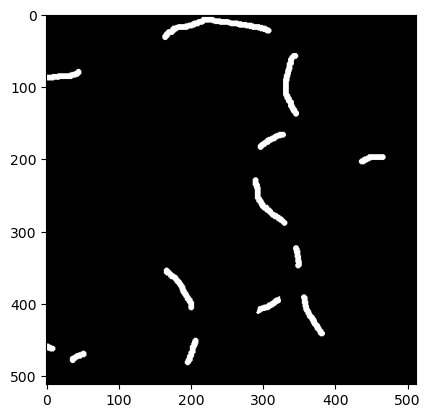

In [27]:
import random
import matplotlib.pyplot as plt
path = "/home/tommytang111/gap-junction-segmentation/data/sem_adult/SEM_split/s250-259/gts"
image = os.path.join(path, random.choice(os.listdir(path)))
print(f"Showing image {image}")
image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
print(np.any(image == 1))
plt.imshow(image, cmap='gray')

In [28]:
#Check for blank masks in mask directory
non_black_images = 0
black_images = 0
count = 0
for image in os.listdir(path):
    image_path = os.path.join(path, image)
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if np.any(img == 1):
        non_black_images += 1
    else:
        black_images += 1
    count += 1
print(f"Non-black images: {non_black_images}/{count}, Black images: {black_images}/{count}")

Non-black images: 40/40, Black images: 0/40
